<a href="https://colab.research.google.com/github/cehkop/MSU_AI-v5/blob/main/L07_Batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">Улучшение сходимости нейросетей и борьба с переобучением</font>

# Сигмоида затухает и теоретически, и практически

Загрузим данные, создадим сеть, обучим ее и посмотрим на практике, как проходит обучение.

Загрузим **датасет MNIST**:

In [ ]:
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# transforms for data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.13), (0.3))]
)

train_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


Создадим сеть с **сигмоидой** в качестве функции активации:

In [ ]:
import torch.nn as nn


class SimpleMNIST_NN(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid):
        super().__init__()
        self.n_layers = n_layers  # Num of layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]  # input layer
        for _ in range(n_layers - 1):  # append num of layers
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))  # 10 classes
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # reshape to [-1, 784]
        x = self.layers(x)
        return x

Код для визуализации результатов обучения моделей:

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

Функция для обучения сети на обучающей выборке:

In [ ]:
import torch

# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

Функция для валидации сети на валидационной выборке:

In [ ]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

Функция для обучения модели:

In [ ]:
from tqdm.notebook import tqdm


def train_model(model, optimizer, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
    return train_history

Создадим и запустим обучение модели с **2-мя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers2_sigmoid"
model = SimpleMNIST_NN(n_layers=2).to(device)
print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

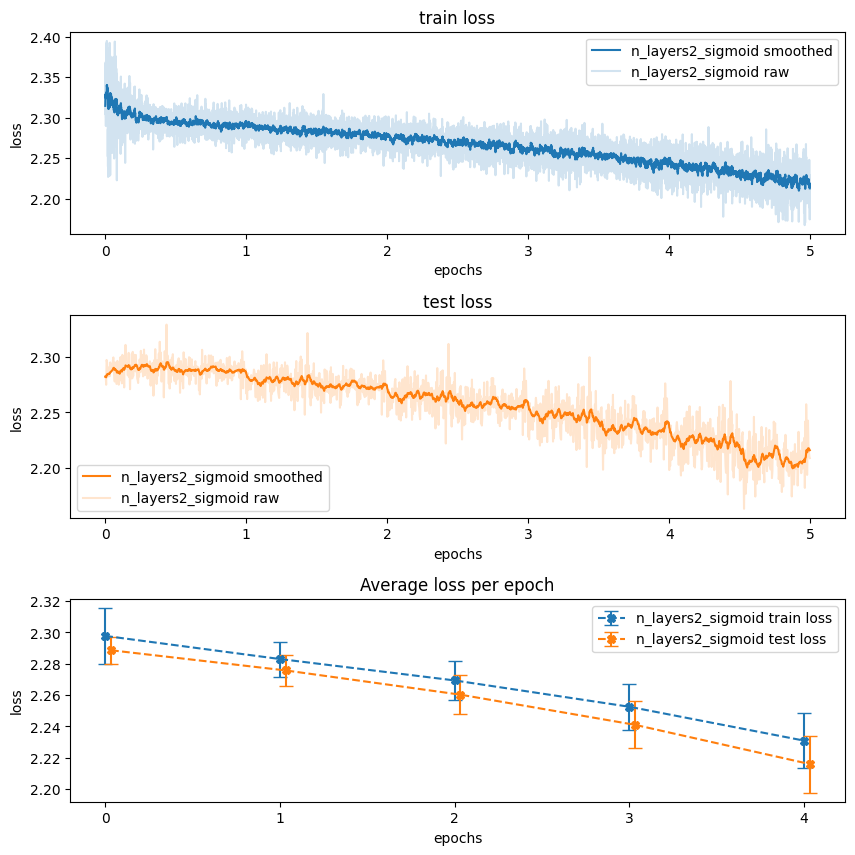

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001)

history = train_model(model, optimizer, model_name=model_name)
history_plotter.add(history)
history_plotter.plot([model_name])

А теперь посмотрим на модель **с 3-мя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers3_sigmoid"
model = SimpleMNIST_NN(n_layers=3).to(device)
print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

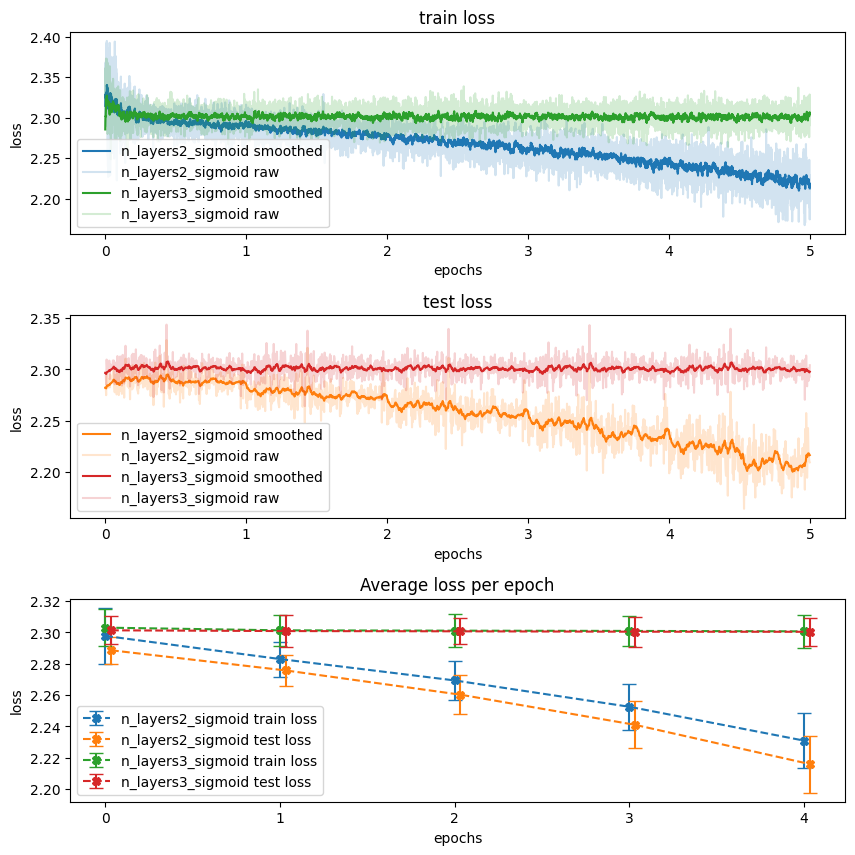

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

history = train_model(model, optimizer, model_name=model_name)
history_plotter.add(history)
history_plotter.plot(["n_layers2_sigmoid", model_name])

**Замечание:** На самом деле, если увеличить learning rate, размер батча или число нейронов, то нейросеть начнет учиться. Это — учебный пример, чтобы показать, что и такое бывает.

Нейросеть с тремя слоями вообще **не учится**. Почему? Можем попробовать разобраться.

Для этого напишем функции, которые будут следить за **распределением градиентов** и **активаций** на наших слоях.

Воспользуемся методом `register_backward_hook` библиотеки PyTorch для того, чтобы выполнять эти функции при каждом пропускании градиента.

In [ ]:
from collections import defaultdict


def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = input_[0].cpu().detach().numpy().flatten()

    return forward_hook


def get_backward_hook(history_dict, key):
    def backward_hook(grad):  # for tensors
        history_dict[key] = grad.abs().cpu().detach().numpy().flatten()

    return backward_hook


def register_model_hooks(model):
    cur_ind = 0
    hooks_data_history = defaultdict(list)
    for child in model.layers.children():
        if isinstance(child, nn.Linear):
            forward_hook = get_forward_hook(
                hooks_data_history, f"sigmoid_out_{cur_ind}"
            )
            child.register_forward_hook(forward_hook)

            cur_ind += 1
            backward_hook = get_backward_hook(
                hooks_data_history, f"gradient_linear_{cur_ind}"
            )
            child.weight.register_hook(backward_hook)
    return hooks_data_history

Запустим обучение **модели с 3 слоями**:

  0%|          | 0/5 [00:00<?, ?it/s]

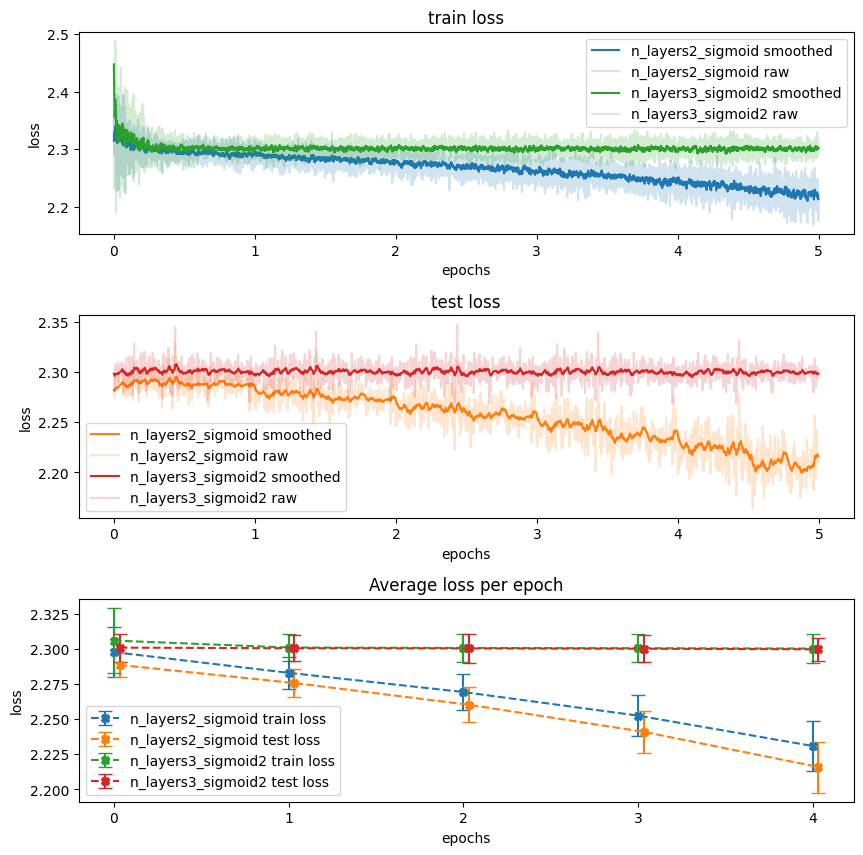

In [ ]:
model = SimpleMNIST_NN(n_layers=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

hooks_data_history = register_model_hooks(model)

model_name = "n_layers3_sigmoid2"
history = train_model(model, optimizer, model_name=model_name)
history_plotter.add(history)
history_plotter.plot(["n_layers2_sigmoid", model_name])

In [ ]:
def plot_hooks_data(hooks_data_history):
    keys = hooks_data_history.keys()
    n_layers = len(keys) // 2

    activation_names = [f"sigmoid_out_{i}" for i in range(1, n_layers)]
    activations_on_layers = [
        hooks_data_history[activation] for activation in activation_names
    ]

    gradient_names = [f"gradient_linear_{i + 1}" for i in range(n_layers)]
    gradients_on_layers = [hooks_data_history[gradient] for gradient in gradient_names]

    for plot_name, values, labels in zip(
        ["activations", "gradients"],
        [activations_on_layers, gradients_on_layers],
        [activation_names, gradient_names],
    ):
        fig, ax = plt.subplots(1, len(labels), figsize=(14, 4), sharey="row")
        for label_idx, label in enumerate(labels):
            ax[label_idx].boxplot(values[label_idx], labels=[label])
        plt.show()

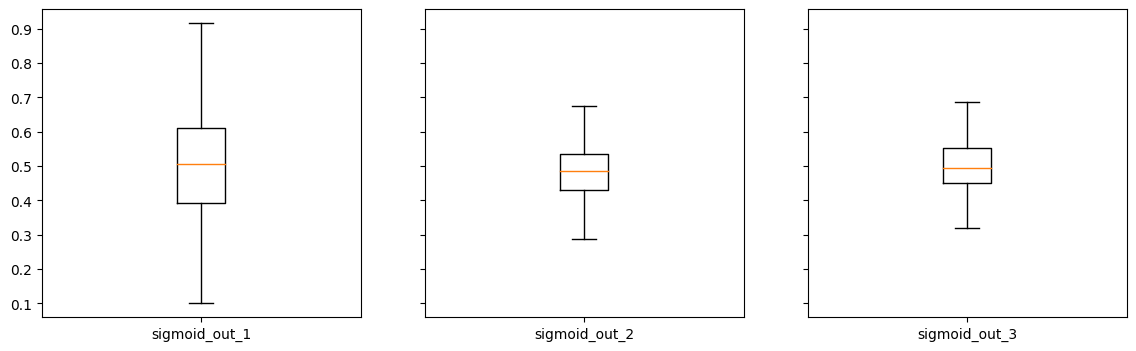

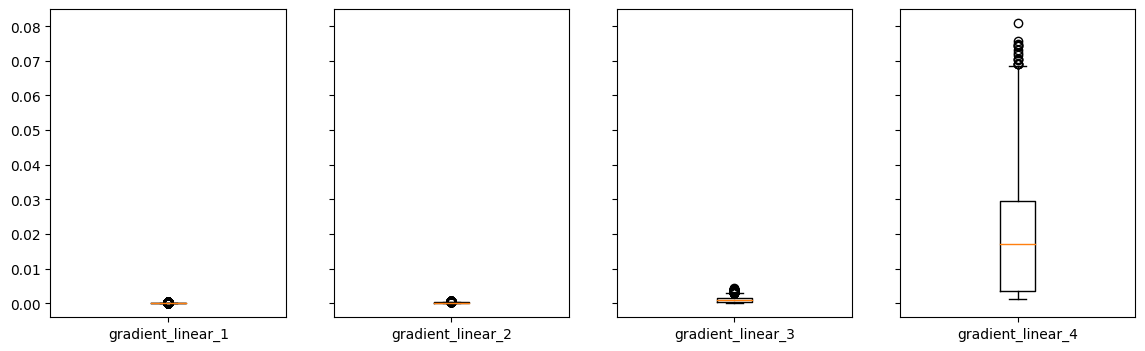

In [ ]:
plot_hooks_data(hooks_data_history)

Мы видим, что градиент нашей модели стремительно затухает. Первые слои (до которых градиент доходит последним), получают значения градиента, мало отличимые от нуля.

Причем, это будет верно с самых первых шагов обучения нашей модели.

Это явление получило название **паралич сети**.





# Затухание градиента

Откуда оно берется?

Посмотрим на обычную сигмоиду

$$\sigma(z) = \dfrac 1 {1 + e^{-z}}$$

Ее производная, как мы уже выводили, равна

$$\dfrac {\partial \sigma(z)} {\partial z} = \sigma(z) (1 - \sigma(z))$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/activation_function_sigmoid.png" width="1000">

Какое максимальное значение у такой функции?

Сигмоида находится в пределах от 0 до 1. **Максимальное значение производной** по сигмоиде  $=\dfrac 1 4$

Теперь возьмем простую нейронную сеть:


<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/simple_nn_with_sigmoid.png" width="750">

Посчитаем у нее градиент

$$\dfrac {\partial L} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial y} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_5z)} {\partial z} w_5 \le \dfrac 1 4 \dfrac {\partial L} {\partial y}  w_5 $$

Аналогично можно посчитать градиент для $z_3$

$$\dfrac {\partial L} {\partial z_3} = \dfrac {\partial L} {\partial z_4} \dfrac {\partial z_4} {\partial z_3} \le \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_4z)} {\partial z} w_5 \le \left({\dfrac 1 4}\right)^2 \dfrac {\partial L} {\partial y}  w_5 w_4$$

И так далее

$$\dfrac {\partial L} {\partial x}  \le \left({\dfrac 1 4}\right)^5 \dfrac {\partial L} {\partial y}  w_5 w_4 w_3 w_2 w_1$$

Таким образом:
* градиент начинает **экспоненциально затухать**, если **веса маленькие**;

* если **веса большие**, то градиент наоборот начнет **экспоненциально возрастать** (взрыв градиента).

Для некоторых функций активации картина будет не столь катастрофична, но тоже неприятна.
При выполнении заданий вы посмотрите, например, как ведет себя функция **ReLU** в этом случае.

Давайте подумаем, что можно сделать с нейронной сетью, чтобы она начала учиться. В начале рассмотрим методы, **не изменяющие структуру сети** (без добавления дополнительных слоев), также зафиксируем количество нейронов и параметры оптимизатора.


# Нормализация входов и выходов

Начнем с уже знакомого: **нормализация**.

## Нормализация входных данных

Представим себе, что данные, которые мы подаем в нейросеть, распределены следующим образом:

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/data_before_normalization.png" width="400">

Фактически нейросети работают со скалярными произведениями. В этом плане два вектора, изображенные на рисунке, **не сильно отличаются**. Также и точки нашего датасета слабо разделимы. Чтобы с этим работать, нейросеть сначала должна подобрать **удобное преобразование**, а затем только сравнивать наши объекты. Понятно, что это усложняет задачу.

Для того, чтобы облегчить нейросети задачу, входные признаки часто **нормируют**:

$$x1' = \dfrac {x1 - \mu_{x1}} {\sigma_{x1}}$$

$$x2' = \dfrac {x2 - \mu_{x2}} {\sigma_{x2}}$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/data_after_normalization.png" width="450">


 Такое преобразование действительно помогает нейросети

$$ \Large J(w,b) = \frac1m \sum L(\hat{y^i}, y^i)$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/normalization_helps_find_minimum_of_function.png" width = "900"></center>

<center><em>Нормализация позволяет искать минимум целевой функции удобнее и быстрее</em></center>

## Нормализация целевых значений в задаче регрессии

В ряде приложений также нужна **нормализация выходных значений**, например, в задаче **регрессии**. Существует несколько причин, почему это необходимо.

### Взрыв градиента

В большинстве случаев, мы **нормализуем входные данные**, чтобы среднее значение было 0.

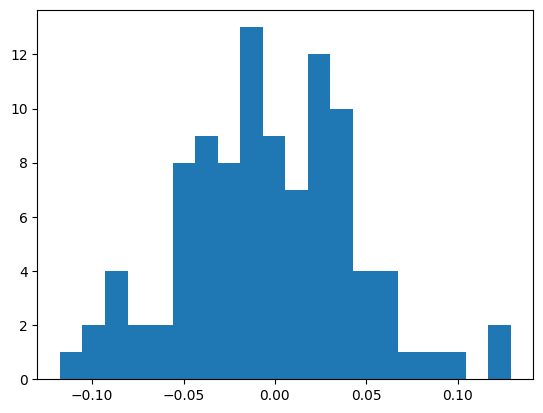

X mean: -0.00 X variance: 1.00


In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn((512, 100))  # Fake normalized data
plt.hist(x.mean(dim=0), bins=20)
plt.show()
print(f"X mean: {x.mean().item():.2f} X variance: {x.var().item():.2f}")

Кроме этого мы определенным **случайным образом инициализируем веса**.

In [ ]:
from torch import nn

net = nn.Sequential(
    nn.Linear(100, 50),  # weights randomly sampled from some random distribution
    nn.Sigmoid(),
    nn.Linear(50, 1),
)

Веса **нормально распределены вокруг нуля**:




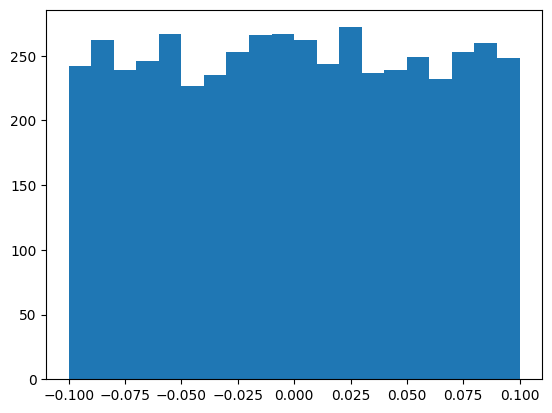

Weights mean: 0.00,  Weights variance: 0.00


In [ ]:
weights = net[0].weight.data.numpy()
plt.hist(weights.flatten(), bins=20)
plt.show()

print(f"Weights mean: {weights.mean():.2f},  Weights variance: {weights.var():.2f}")

Необученная сеть будет чаще всего предсказывать значения порядка $10^{-1}$.

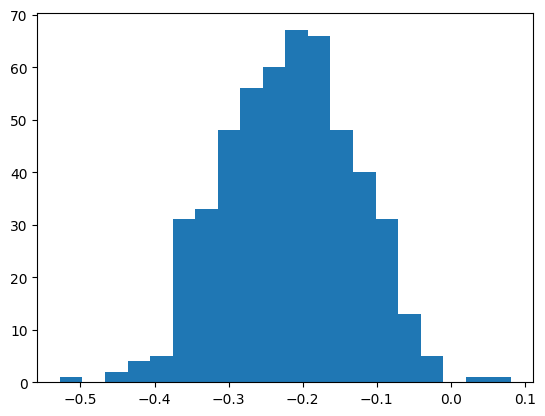

Out mean: -0.22, Out variance: 0.01


In [ ]:
out = net(x)
plt.hist(out.detach().numpy(), bins=20)
plt.show()

print(f"Out mean: {out.mean().item():.2f}, Out variance: {out.var().item():.2f}")

Предположим, мы предсказываем какую-то большую величину. Например, [стоимость дома в штате Калифорния в долларах](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) (в датасете в sklearn целевое значение отнормированно на 100 000\$). Стоимость лежит в диапазоне от 15 000\$ до 500 000\$.

Выберем случайные значения в этом диапазоне.

In [ ]:
# fake cost
targets = torch.randint(15_000, 500_000, (512, 1), dtype=torch.float32)
print(f"Target example: {targets[:10].flatten()}")

Target example: tensor([493536., 444147., 105073., 128527., 212621., 499482., 427085.,  61938.,
        188614., 152376.])


Если мы будем пытаться предсказывать эти значения, мы получим **очень большую ошибку**.

In [ ]:
criterion = nn.MSELoss()
loss = criterion(out, targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 84912406528.00


Эта ошибка приведет к **большим значениям градиента** (cмотрим на значения по x), **большим значениям весов** и **нестабильному обучению**.

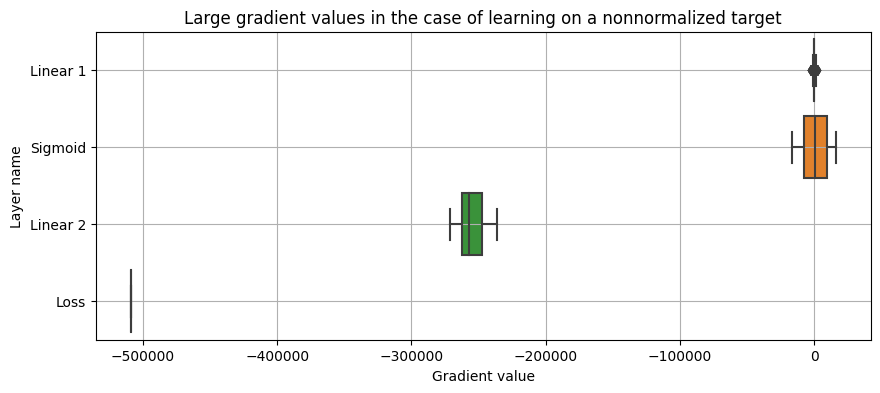

In [ ]:
import pandas as pd
import seaborn as sns

layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())
    # print(f"{layer_name} grad: \n {p.grad}")

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on a nonnormalized target")
plt.show()

Если мы **стандартизуем целевые значения**

In [ ]:
mean = targets.float().mean()
std = targets.float().std()

transformed_targets = (targets - mean) / std
print(transformed_targets.flatten()[:10])

tensor([ 1.6824,  1.3348, -1.0515, -0.8864, -0.2946,  1.7242,  1.2147, -1.3550,
        -0.4636, -0.7186])


То получим ошибку на 10 порядков **меньше**:

In [ ]:
net.zero_grad()
out = net(x)
loss = criterion(out, transformed_targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 1.04


И **небольшие градиенты** (cмотрим на значения по x)


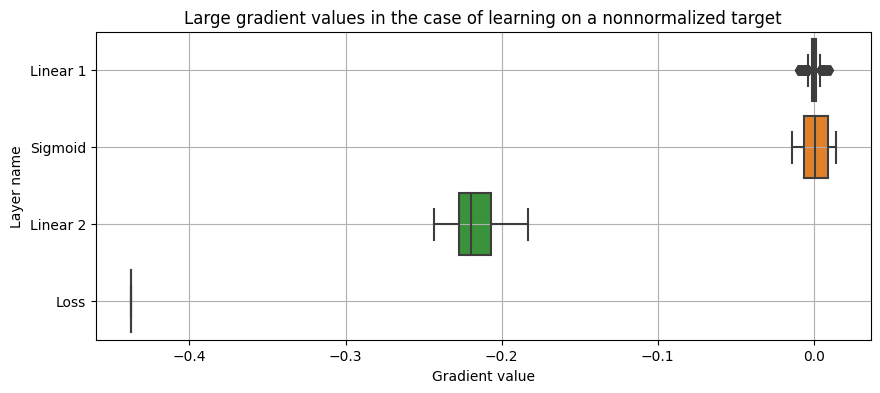

In [ ]:
layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())
    # print(f"{layer_name} grad: \n {p.grad}")

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on a nonnormalized target")
plt.show()

### Multi-Dimensional регрессия

В ряде задач, например, при [**использовании нейронных сетей для моделирования физических процессов**](https://arxiv.org/abs/2007.13875), в задаче регрессии необходимо вычислять **несколько целевых значений**. При этом необходимо помнить, что в качестве функционала ошибки в задачах регрессии часто выбирается **метрика расстояния**, а физические величины могут иметь **различный порядок** и **диапазон значений**. Не самая лучшая идея — считать расстояние, когда по одной оси отложены нанометры, а по другой — килограммы.


В физических задачах полезно изучить, какие нормировки используют в **численных методах** для получения [безразмерных (**dimensionless**) величин](https://www.physics.umd.edu/perg/MathPhys/content/2/pstruc/dimsDE.htm). Это может подсказать хорошую, физически обоснованную нормировку.


Также полезно посмотреть в сторону [**multi-task learning**](https://www.mdpi.com/2076-3417/9/22/4748) с добавлением весов в Loss функцию и выделением специальных слоев для различных физических величин:
$$Loss = \sum_{i=1}^nα_i\cdot Loss_i$$

где $Loss_i$ — значение Loss отдельных выходов, $\alpha_i$ — коэффиценты, которые являются гиперпараметрами модели и подбираются из требований к точности.



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/multi-task.webp" width="550"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2007.13875.pdf">Multi-Task Learning for Multi-Dimensional Regression:
Application to Luminescence Sensing</a></em></center>

# Инициализация весов

Одним из способов борьбы с затухающим градиентом является правильная **инициализация весов**. Как это сделать?

**Идея 1:** инициализировать все веса константой.

Проблема: градиент по всем весам будет одинаков, как и обновление весов. Все нейроны в слое будут учить одно и то же, или, в случае $const = 0$ и активации ReLU, [не будут учиться вообще](https://habr.com/ru/post/592711/).

Вывод: в качестве начальных весов нужно выбирать различные значения.

**Идея 2:** инициализировать веса нормальным (Гауссовским) шумом с матожиданием 0 и маленькой дисперсией.

Маленькая дисперсия нужна, чтобы не получить огромные градиенты за большие изначальные ошибки в предсказании.

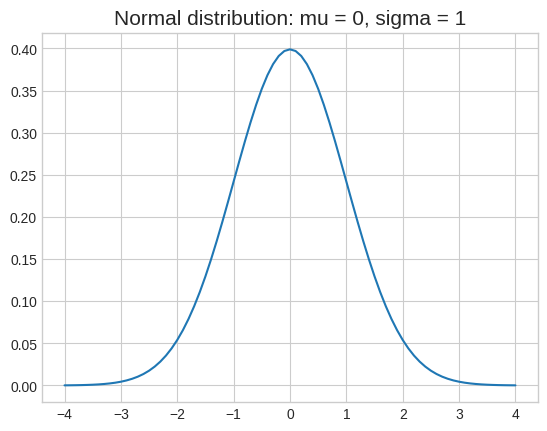

In [ ]:
# Normal distribution: mu = 0, sigma = 1

x = np.arange(-4, 4.1, 0.1)
y = np.exp(-np.square(x) / 2) / np.sqrt(2 * np.pi)

plt.style.use("seaborn-v0_8-whitegrid")
plt.title("Normal distribution: mu = 0, sigma = 1", size=15)
plt.plot(x, y)
plt.show()

Проблема: инициализация нормальным шумом не гарантирует отсутствие взрыва или затухания градиета.

**Идея 3:** формализуем условия, при которых не будет происходить взрыв или затухание градиентов.

1. Нам бы хотелось, чтобы **дисперсии признаков**, получаемых на каждом слое, были одинаковы (т.е мы хотим задать начальные веса таким образом, чтобы входные признаки каждого линейного слоя были **одинаково нормализованы**).

Это важно, т.к. значения признаков используются при расчете градиента. Например, для линейного слоя:
$$y = wx+b$$
$$\dfrac{\partial y} {\partial w} = x$$

Запишем это условие:

$$Dz^i = Dz^j. \tag{1}$$

2. Нам бы хотелось, чтобы **дисперсии градиентов** для разных слоев были одинаковы:

$$D\dfrac {\partial L} {\partial z^i} = D\dfrac {\partial L} {\partial z^j}. \tag{2}$$


При выполнении этих условий градиент **не затухает** и **не взрывается**.

Инициализации Ксавье и Каймин Хе пытаются выполнить эти условия.

## Инициализация Ксавье (Xavier Glorot)

Рассмотрим функцию активации **гиперболический тангенс** (Tanh).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/simple_nn_with_tanh.png" width="600">

Это — [нечетная функция](https://ru.wikipedia.org/wiki/%D0%A7%D1%91%D1%82%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8) с единичной производной в нуле. Функция и ее производная изображены ниже.

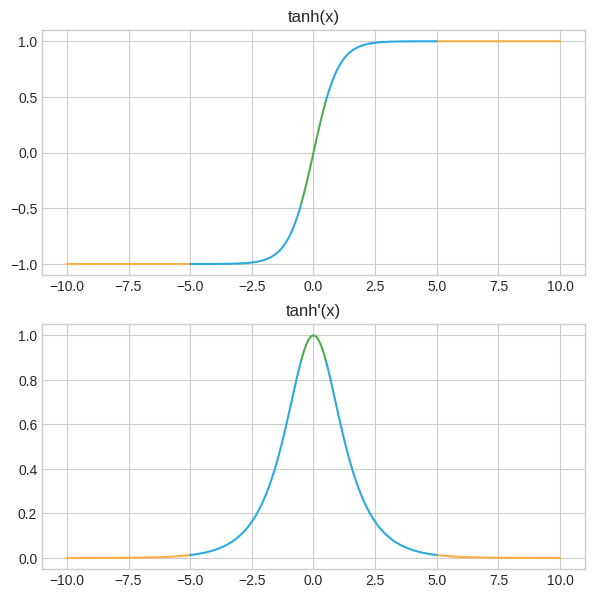

In [ ]:
x = np.arange(-10, 10.1, 0.1)
y = np.tanh(x)
dy = 1 / np.cosh(x)

plt.style.use("seaborn-v0_8-whitegrid")
fig, (im1, im2) = plt.subplots(2, 1, figsize=(7, 7))
im1.set(title="tanh(x)")

# fmt: off
im1.plot(x[0:51], y[0:51], "#F9B041",
         x[150:201], y[150:201], "#F9B041",
         x[50:96], y[50:96], "#2DA9E1",
         x[105:151], y[105:151], "#2DA9E1",
         x[95:106], y[95:106], "#4AAE4D",)
im1.grid(True)
im2.set(title="tanh'(x)")
im2.plot(x[0:51], dy[0:51], "#F9B041",
         x[150:201], dy[150:201], "#F9B041",
         x[50:96], dy[50:96], "#2DA9E1",
         x[105:151], dy[105:151], "#2DA9E1",
         x[95:106], dy[95:106], "#4AAE4D",)
# fmt: on

im2.grid(True)
plt.show()

Третья интуиция, которая нам понадобится: нам важно не попасть в <font color='#F9B041'>**оранжевые**</font>  зоны с почти нулевой производной, т.к. в этих областях градиент затухает. Мы хотим инициализировать веса таким образом, чтобы признаки, поступающие на слой активации, находились в <font color='#4AAE4D'>**зеленой**</font> области в окрестности нуля. Матожидание признаков, поступающих на слой активации, будет равно нулю
$$E(z^i_t w_{kt})=0.$$



Можно  [показать](https://github.com/Gan4x4/ml_snippets/blob/main/Training/Weights_initipynb.ipynb), что в <font color='#4AAE4D'>**зеленой**</font> области условия $(1)$ и $(2)$ можно переписать как:

$$n_iDW^i = 1$$
$$n_{i+1}DW^i = 1$$

где где $n_i$ — размерность выхода слоя i-го слоя.


Если размерность слоев отличается, то условия невыполнимы одновременно:

 $$n_i \ne n_{i+1}. $$

На практике хорошо работает компромисс — среднее гармоническое решений первого $\dfrac 1 {n_i}$ и второго $\dfrac 1 {n_{i+1}}$ уравнения:

$$DW^i = \dfrac 2 {n_i + n_{i+1}}.$$

**Итого:** нам нужно инициализировать веса нейронов случайными величинами со следующими матожиданием и дисперсией:

$$ EW^i = 0,$$

$$DW^i = \dfrac 2 {n_i + n_{i+1}}.$$

Мы можем взять [равномерное распределение](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BF%D1%80%D0%B5%D1%80%D1%8B%D0%B2%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B2%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5). Именно такое распределение было предложено в [статье](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf):

$$W_i \sim U[a, b ],$$

где $a=-b$, так как матожидание равно 0

Дисперсия которого выражается формулой:
$$D(U[a, b]) = \dfrac 1 {12} (b -a)^2 = \dfrac 4 {12} b^2 = \dfrac 1 {3} b^2.$$

Получим:

$$ b = \sqrt{\dfrac {6} {n_i + n_{i + 1}}}$$

**Итого:**

$$W_i \sim U[-\sqrt{\dfrac {6} {n_i + n_{i + 1}}}, \sqrt{\dfrac {6} {n_i + n_{i + 1}}}],$$

где $n_i$ — размерность выхода слоя n-го слоя.




Можно использовать и другие распределения, например [нормальное](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5). Для него получится:
$$W_i \sim N (0,  std=\sqrt{\dfrac{2}{n_i + n_{i + 1}}})$$
Результат получится аналогичный.


Чтобы понять, что происходит с выходами слоя активации при использовании инициализации Xavier, рассмотрим картинку из оригинальной статьи [Xavier, Yoshua, "Understanding the difficulty of training deep feedforward neural networks", Aistats, 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf):

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/xavier_procentile_and_deviation_with_and_without_init.png" width="600"></center>

<center><em>Source: <a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf">Understanding the difficulty of training deep feedforward neural networks</a></em></center>

На картинке изображена зависимость 98-[процентиля](https://en.wikipedia.org/wiki/Percentile) (отдельные маркеры) и стандартного отклонения (соединенные маркеры) значений на выходе слоя активации $tanh$ от эпохи обучения для различных слоев нейросети.

Верхнее изображение — инициализация весов с помощью нормального распределения $W_i \sim U[-\dfrac {1} {\sqrt{n_i}}, \dfrac {1} {\sqrt{n_i}} ]$. Нижнее — с использованием инициализации Xavier.

На верхнем изображении видно, как значения 98-процентиля уходят в значения +1 и -1 (сначала на выходе первого слоя, потом на выходе второго и т.д.). Это значит, что для части нейронов происходит затухание градиентов (они переходят в область, отмеченную на графиках $tanh(x)$, $tanh’(x)$ <font color='#F9B041'>**оранжевым**</font>  и перестают учиться). На нижней картинке такого не происходит.

Xavier используется для симметричных функций активаций, таких как **tanh** и **sigmoid**.


Вообще говоря, коэффициенты в инициализациях (числитель в формуле для дисперсии), зависят от конкретной **выбранной функции активации**.
В PyTorch есть [функции](https://pytorch.org/docs/stable/nn.init.html) для вычисления этих коэффициентов.


## Инициализация Каймин Хе (Kaiming He)

Для функции активации **ReLU** и ее модификаций (**PReLU**, **Leaky ReLU** и т.д.) аналогично инициализации Xavier можно расписать условия $(1)$, $(2)$. Так вводится He-инициализация.

Условия $(1)$, $(2)$ эквивалентны условиям:

$$  \dfrac {n_iDW^i} {2}  = 1, $$

$$\dfrac {n_{i+1}DW^i} {2} = 1.$$

Можно опять взять среднее гармоническое. Но на практике берут либо $\displaystyle \frac 2 {n_i}$, либо $\displaystyle \frac 2 {n_i + 1}$.

Итого получим для нормального распределения:

$$W^i \sim N(0, std=\sqrt{\frac 2 {n_i}})$$

Для равномерного распределения:
$$W^i \sim U(-\sqrt{\frac 3 {n_i}}, \sqrt{\frac 3 {n_i}})$$

Более подробно с выводом инициализации Каймин Хе можно ознакомиться в оригинальной [статье](https://arxiv.org/pdf/1502.01852v1.pdf).

## Важность инициализации весов

1. Нейросеть может **сойтись значительно быстрее**. Графики для активации **ReLU**:


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/weight_initialization_influence_convergence_neural_networks.png" width="550">

<em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em>

2. В зависимости от выбранной активации сеть вообще может **сойтись или не сойтись**. Графики для активации **ReLU**:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/activation_function_influence_convergence_neural_networks.png" width="550">

<em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em>

## Ортогональная инициализация

Другой идеей является **ортогональная инициализация**.
[Преобразование](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%BE%D0%B5_%D0%BE%D1%82%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5), заданное [ортогональной матрицей](https://ru.wikipedia.org/wiki/%D0%9E%D1%80%D1%82%D0%BE%D0%B3%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0), **не изменяет расстояние между точками**. Можно представить **ортогональную матрицу** как [матрицу поворота](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%BF%D0%BE%D0%B2%D0%BE%D1%80%D0%BE%D1%82%D0%B0) (это не совсем верно, т.к. матрицы перестановки тоже ортогональны), т.е. линейный слой будет **разворачивать** карту признаков, чтобы собирать их линейные коомбинации, **не изменяя масштаб признаков**.


Для каждого слоя мы убеждаемся, что изначальная матрица весов является ортогональной.

Выберем ортогональную матрицу весов
$$W: WW^T = 1$$

Тогда:
1.  Норма активации сохраняется (опять же, активации между слоями остаются в одном масштабе):
$$||s_{i+1}|| = ||W_{i}s_i|| = ||s_i||$$

2.  Все нейроны делают «разные» преобразования:
$$ ⟨W_i, W_j⟩ = 0~i \ne j$$
$$ ⟨W_i, W_j⟩ = 1~i = j$$


Замечание: т.к. ортогональные матрицы бывают только квадратные, то этот метод подходит только для слоев с одинаковым количеством входных и выходных значений.


Иногда такая инициализация обеспечивает значительно лучшую сходимость, [тут](https://arxiv.org/pdf/1312.6120.pdf) можно почитать об этом подробнее.

## Инициализация весов в PyTorch

Для инициализации весов PyTorch используется модуль `torch.nn.init`

В нем определены разные функции для инициализации весов.

Нюанс состоит в том, что обычно для слоев разного типа может требоваться разная инициализация. Поэтому в функции, которая инициализирует слои вашей нейронной сети, желательно прописывать разное поведение для разных слоев.

Попробуем, например, добавить в нашу нейросеть инициализацию. Нам нужна инициализация Xavier, так как у нас `nn.Sigmoid`

Метод `torch.nn.init.calculate_gain` возвращает рекомендуемое значение коэффициента масштабирования для стандартного отклонения заданной функции активации.

In [ ]:
class SimpleMNIST_NN(nn.Module):

    def __init__(self, n_layers, activation=nn.Sigmoid, init_form="normal"):
        super().__init__()
        self.n_layers = n_layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

    # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("sigmoid")
        for child in self.layers.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight, gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight, gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

Запустим обучение модели с инициализацией весов Xavier:

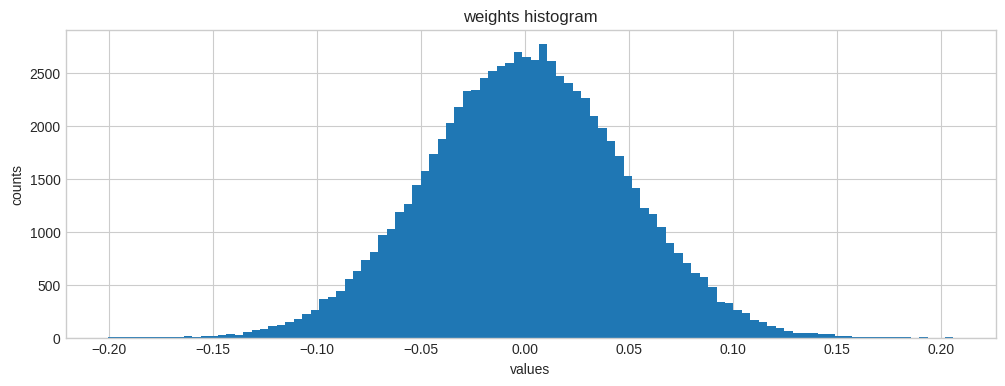

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model = SimpleMNIST_NN(n_layers=3, init_form="normal").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# plotting weights values of first(input layer)
plt.figure(figsize=(12, 4))
plt.hist(
    list(model.layers.children())[0].weight.cpu().detach().numpy().reshape(-1), bins=100
)
plt.title("weights histogram")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

model_name = "n3_layers_sigmoid_havier"
history = train_model(model, optimizer, model_name=model_name)

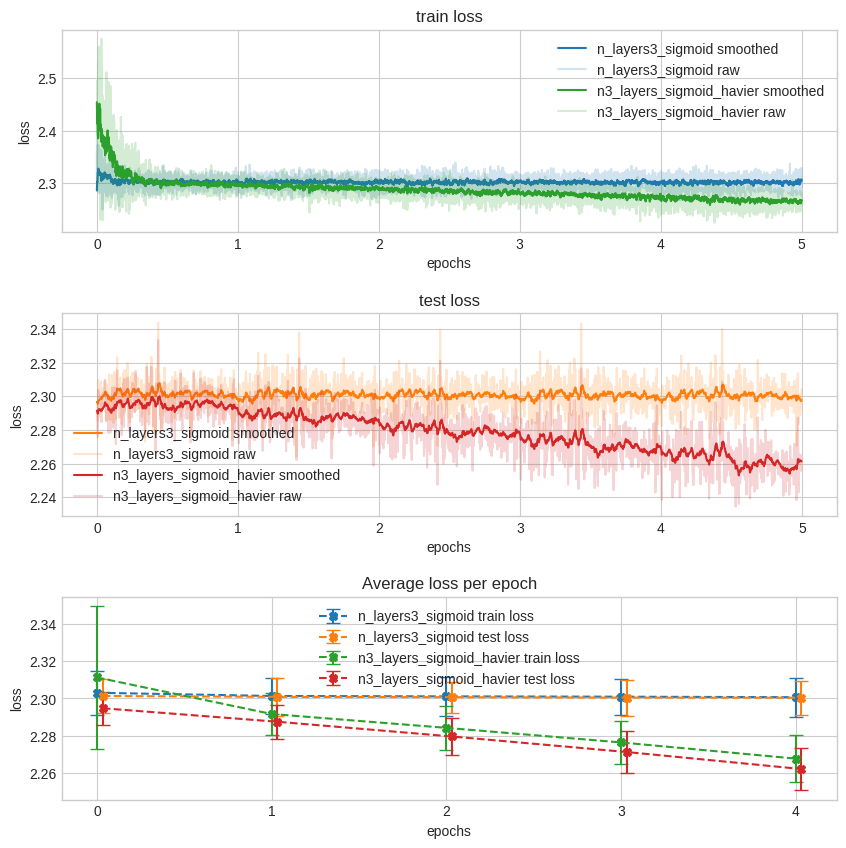

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n_layers3_sigmoid", model_name])

Видим, что нейросеть стала хоть как-то учиться.

# Слои нормализации

## Covariate shift (Ковариантный сдвиг)

**Covariate shift** &mdash; явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**. Ковариантный сдвиг может стать серьезной проблемой для практического применения моделей.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/covariate_shift.png" width="450"></center>

Модель учится сопоставлять целевые значения признакам. В такой ситуации модель не в состоянии делать адекватные предсказания на тесте, так как во время обучения она не видела области пространства, в которой расположены тестовые объекты.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/covariate_shift_problem.png" width="450"></center>

Выделяют **два источника ошибок**, приводящих к **ковариантному сдвигу**:

1. **Систематические ошибки**:
*   *Ошибки при сборе данных* (предвзятый метод сбора данных, нерепрезентативная выборка).

**Пример:** стандартные наборы данных для задачи **Face Recognition** не сбалансированы по полу, возрасту и этнической принадлежности, поэтому обученные на них модели могут плохо работать с редкими классами. Это привело к обвинениям таких корпораций, как Microsoft, IBM и Amazon, в [расизме](https://sitn.hms.harvard.edu/flash/2020/racial-discrimination-in-face-recognition-technology/).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/face_recognition_racism.webp" width="1000"></center>
<center><em>Source: <a href="https://sitn.hms.harvard.edu/flash/2020/racial-discrimination-in-face-recognition-technology/">Racial Discrimination in Face Recognition Technology</a></em></center>

**Что делать?**
Следить за репрезентативностью данных, использовать Importance Reweighting (при обучении давать больший вес редким объектам).


*  *Различие условий сбора данных для train и test выборки*

**Пример:** Задачи компьютерного зрения. Данных для обучения может быть недостаточно, поэтому часто для обучения используют датасеты из Интернета. При этом условия съемки (качество, разрешение, освещенность) train и test выборок могут отличаться.

**Что делать?** Аугментировать данные с учетом условий применения.

* *Ошибки предобработки данных*

**Пример:** В картах пациентов больницы А, использованных для train, рост пациента указан метрах, в картах пациентов больницы Б, использованных для test, рост пациента указан в футах. При составлении датасета данные не привели к одной **единице измерения**.


**Что делать?** Искать ошибку.

2. **Нестационарная среда**

При обучении мы используем ограниченный набор признаков и объектов. При этом есть факторы, которые мы можем не учесть: износ оборудования, изменение политических условий и т.д., что может приводить к постепенной или резкой деградации модели при применении ее в реальных условиях.

**Что делать?**
* Удалять из модели маловажные нестационарные признаки.
* Дообучать модель на новых данных.
* [Компенсировать сдвиг](https://www.researchgate.net/publication/339021786_Covariate_Shift_A_Review_and_Analysis_on_Classifiers).

**Замечание:** Просадка качества на test выборке может быть также связана с **проблемами обобщающей способности модели**. Причины могут быть разными, например переобучение под validate выборку или отсутствие связи между признаками и целевым значением (задача в данной постановке не решается).

**Практический совет:** для быстрого обнаружения ковариантного сдвига можно **обучить модель**, которая будет предсказывать, относится ли объект к **train** или **test выборке**. Если модель легко делит данные, то имеет смысл визуализировать значения признаков, по которым она это делает.


## Internal covariate shift

В статье [“Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift”](https://arxiv.org/pdf/1502.03167.pdf) 2015 года авторы предположили, что похожее явление имеет место внутри нейросети, назвав его **internal covariate shift**.

**Internal covariate shift** — это изменение распределения выхода слоя активации из-за изменения обучаемых параметров во время обучения.

Пусть у нас $k$-ый нейрон $i$-го слоя переводит выход $i$-1 слоя с распределениями <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в новое пространство с распределением <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/internal_covariate_shift_example.png" width="1000">

При обучении:
- нейросеть делает предсказание,
- считается значение функции потерь,
- делается обратное распространение ошибки,
- обновляются веса.


После обновления весов $k$-ый нейрон $i$-го слоя будет переводить выходы $i$-1 слоя <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в пространство с другим распределением <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

При этом $i$+1 слой учился работать со старым распределением  <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>, и будет хуже обрабатывать <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

### Плохой вариант борьбы с этим

Давайте на каждом слое просто нормировать **каждый признак** (выход каждого нейрона), используя среднее и дисперсию по батчу

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$




Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/domain_of_linear_of_sigmoid_function.png" width="500">

Получаем набор линейных слоев фактически без функций активации, следовательно, все вырождается в однослойную сеть. Не то, что нам надо.

## Batch Normalization

Нам надо дать нейронной сети **возможность перемещать распределение выходов** слоя из области 0 и самой **подбирать дисперсию**. Для этой цели используется **батч-нормализация** (*batch normalization*), которая вводит в нейронную сеть дополнительную операцию между соседними скрытыми слоями. Она состоит из **нормализации** входящих (в слой батч-нормализации) значений, полученных от скрытого слоя, **масштабирования** и **сдвига** с применением двух новых параметров и передачи полученных значений на вход следующему скрытому слою.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnormalization.png" width="800">

Параметры, используемые в батч-нормализации ($\gamma$ — отвечающий за **сжатие** и $\beta$ — отвечающий за **сдвиг**), являются **обучаемыми параметрами** (наподобие весов и смещений скрытых слоев).

Помимо обучаемых параметров $\gamma$ и $\beta$ в слое батч-нормализации существуют также необучаемые параметры: **скользящее среднее матожидания** (_Mean Moving Average_) и **скользящее среднее дисперсий** (_Variance Moving Average_), служащие для сохранения состояния слоя батч-нормализации.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnorm_layer_parameters.png" width="900">

Параметры $\gamma$, $\beta$, а также оба скользящих средних вычисляются для каждого слоя батч-нормализации отдельно и являются векторами с **длиной, равной количеству входящих признаков.**

В процессе обучения мы подаем в нейронную сеть **по одному мини-батчу за раз**. Процедуру обработки значений одного признака $x^{(k)}$ (фиолетовая колонка на изображении ниже), который для краткости мы будем обозначать $x$,  из одного мини-батча $ B = \{x_{1},\ldots, x_{m}\} $ можно представить следующим образом:



<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batch_normalization_compute_moving_average.png" width="1000">

Шаг **масштабирования** Gamma $γ$ и шаг **сдвига** Beta $β$ являются главным новшеством батч-нормализации, поскольку в отличие от предыдущего рассмотренного примера, нормированные значения больше не обязаны иметь среднее, равное 0, и единичную дисперсию. Батч-нормализация позволяет сдвигать среднее нормированных значений и масштабировать дисперсию. Фактически, теперь **нейросеть даже может отменить нормализацию входных данных, если считает ее ненужной.**

Для наглядности проиллюстрируем размерности промежуточных переменных на следующем изображении:

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batch_normalization_compute_moving_average_scheme.png" width="1000">

После прямого прохода параметры $\gamma$ и $\beta$ **обновляются через обратное распространение ошибки** так же, как и веса скрытых слоев.

### Скользящее среднее

Выше мы обсуждали то, что в процессе обучения слой **батч-нормализации** рассчитывает значение **среднего и дисперсии** каждого признака в соответствующем **мини-батче**. Предположим, нам нужно сделать предсказание на **одном объекте.** Во время предсказания батч у нас уже отсутствует — откуда брать среднее и дисперсию?

Во время предсказания используется **скользящее среднее**, которое было **рассчитано и сохранено в процессе обучения**.

$$ \mu_{mov_{B}} = (1-\alpha)\mu_{mov_{B-1}}+\alpha\mu_{B} $$

$$ \sigma_{mov_{B}} = (1-\alpha)\sigma_{mov_{B-1}}+\alpha\sigma_{B} $$

Обычно используется параметр $\alpha = 0.1$

Для перевода модели из режима обучения в режим тестирования и обратно в PyTorch используются `model.train()` и `model.eval()`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Батч-нормализация использует статистику по батчу.}}&\large{\text{Батч-нормализация использует скользящие средние.}}\\
\large{\text{Cкользящие средние копятся.}}
\end{array}
$$



Почему используется именно **скользящее среднее**, а **не статистика всей обучающей выборки**?

При таком подходе нам бы пришлось хранить **средние всех признаков** для **всех батчей**, пропущенных через нейросеть в ходе обучения. Это ужасно невыгодно по памяти. Вместо этого **скользящее среднее** выступает в качестве приближенной оценки **среднего и дисперсии** обучающего набора. В этом случае эффективность использования ресурсов увеличивается: нам нужно **хранить в памяти только одно число** — значение скользящего среднего, полученное на последнем шаге.

Проиллюстрировать преимущество использования скользящего среднего можно на следующем примере:

Предположим, что у нас есть массив объектов, обладающих некоторым признаком $x$ (обучающая выборка), и некоторый черный ящик, извлекающий по $k$ объектов из этого массива (Dataloader). Наша задача — дать оценку ожидаемому среднему этих $k$ объектов. В данном примере для простоты будем извлекать $k$ объектов из некоего распределения случайным образом:

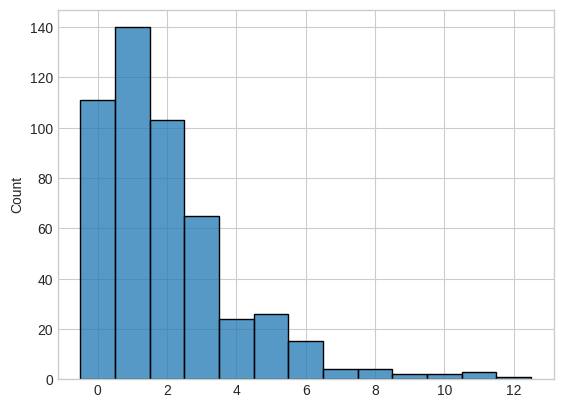

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

k = 500  # sample size
n = 2
p = 0.5

sample = np.random.negative_binomial(n, p, k)
sns.histplot(data=sample, discrete=True)
plt.show()

Оценить ожидаемое среднее теоретически, не зная, как распределен признак $x$ наших объектов, трудно. Мы можем собрать **большое количество средних** и произвести оценку с их помощью, но для этого нам потребуется хранить в памяти все эти значения, что приведет к неэффективному расходу ресурсов. Более эффективным решением будет воспользоваться **скользящим средним**. Давайте сравним эти два метода:

In [ ]:
ema = 0
alpha = 0.01
means = np.array([])

for i in range(10000):
    sample = np.random.negative_binomial(n, p, 50)
    ema = (1 - alpha) * ema + alpha * sample.mean()
    means = np.append(means, sample.mean())

Посчитаем количество памяти, затрачиваемое на хранение списка средних значений признака $x$ по выборкам из $k$ объектов, и **количество памяти**, затрачиваемое на хранение **скользящего среднего**:

In [ ]:
import sys

print(f"{sys.getsizeof(ema)} bytes")

32 bytes


Количество памяти для хранения **списка средних**:

In [ ]:
print(f"{sys.getsizeof(means)} bytes")

80112 bytes


Видно, что на хранение массива средних значений расходуется на порядки больше памяти, чем на хранение одного скользящего среднего. Теперь давайте воспользуемся тем, что мы сэмплировали случайные выборки из известного распределения, и можем теоретически рассчитать их среднее. В нашем примере мы извлекали выборки из негативного биномиального распределения с параметрами $n=2$ и $p=0.5$, для которого среднее рассчитывается по формуле $mean=\frac{np}{1-p}=2$. Мы знаем, что при достаточно большом количестве сэмплированных выборок среднее распределения выборочных средних будет стремиться к среднему генеральной совокупности. Сравним результаты, полученные с использованием сохраненных выборочных средних и скользящего среднего с теоретическим расчетом:

Среднее признака $x$ по $k$ объектам, оцененное с помощью **скользящего среднего**:

In [ ]:
print(f"{ema:.8f}")

2.00626164


Среднее признака $x$ по $k$ объектам, **оцененное по всем сэмплированным выборкам**:

In [ ]:
print(f"{means.mean():.8f}")

2.00472600


Видно, что мы получили довольно точную оценку, использовав скользящее среднее.

### Защита от нулей в знаменателе

Чтобы у нас не мог возникнуть 0 в знаменателе, добавляем маленькое число — $\epsilon$. Например, равное 1e-5


$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$ BN_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

### Сверточные слои

Сверточный слой можно свести к линейному слою. BatchNorm можно применять и для линейных слоев, и для сверточных.

Признаки внутри одного канала (одной карты признаков) получаются путем применения к исходному изображению одних и тех же преобразований. По сути **1 канал** - это **карта одного признака**. Поэтому логично, что нормализация будет происходить по каналам, а одним признаком считаться одна  **feature map**.
Нормализация идет по всей такой feature map (по всему каналу) для всех объектов батча.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/feature_map.png" width="500">

В PyTorch для полносвязных слоев используют [`nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), а для сверточных [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

Графически нормализации часто объясняют при помощи следующей схемы:

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/dimensions_channels_batch_samples.png" width="450">

*По оси абсцисс* расположены **объекты из батча**,  
*по оси ординат* &mdash; **feature map**, преобразованный в вектор,  
*по оси аппликат* &mdash; **каналы** (feature maps).

В этом представлении **BatchNorm** для свертки выглядит следующим образом:

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/visualization_of_batch_normalization.png" width="450">

[Batch Normalization](https://paperswithcode.com/method/batch-normalization)

### Пример работы

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/batchnorm_efficiency.png" width="550">

<em>Source: <a href="https://arxiv.org/pdf/1502.03167.pdf">Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shiftn</a></em>



Этот метод действительно работает.
Видим, что нейросети с батч-нормализацией:

1. **Сходятся быстрее**, чем нейросети без неё.
2. Могут работать с **более высоким начальным значением learning rate**, причем это позволяет достигать лучших результатов.
3. Работают даже с функцией активации в виде **сигмоиды**. Без **BatchNorm** такая сеть не обучилась бы вовсе.

### Градиент

Вычисление **градиента BatchNorm** — интересное упражнение на понимание того, как работает **backpropagation**. В лекции мы это опускаем, можете ознакомиться самостоятельно:

[Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)



### Batch Normalization как регуляризация

Почему для нейросети с батчнормализацией можно использовать более высокие learning rate?

Оказывается, **батч-нормализация** делает **неявную регуляризацию на веса**.

Допустим, мы решили **увеличить веса** в $a$ раз.

Так как мы шкалируем, то домножение весов $W$ на константу выходных значений слоя не меняет

$$BN((aW)u) = BN(Wu)$$

Градиент слоя по входу не меняется

$$\dfrac {\partial BN((aW)u)} {\partial u} = \dfrac {\partial BN(Wu)} {\partial u}$$

А **градиент по весам уменьшается** в $a$ раз

$$\dfrac {\partial BN((aW)u)} {\partial aW} = \dfrac 1 a \dfrac {\partial BN(Wu)} {\partial W} $$

Таким образом, нейросеть автоматически не дает большим весам расти

### Сглаживающий эффект Batch Normalization

**Batch Normalization** была разработана на идее необходимости коррекции **Internal covariate shift**. В 2019 году вышла статья [How Does Batch Normalization Help Optimization?](https://arxiv.org/pdf/1805.11604.pdf), которая показала, что влияние коррекции **Internal covariate shift** на качество обучения не так велико, как считали авторы **Batch Normalization**.

Другим интересным эффектом Batch Normalization оказалось **сглаживание ландшафта** функции потерь. Batch Normalization улучшает гладкость пространства решений и облегчает поиск в нем минимума. Именно благодаря сглаживанию ландшафта Batch Normalization справляется с затуханием и взрывом градиента.


<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnorm_helps_find_minimum_of_function.jpg" width="900">

### Советы по использованию Batch Normalization

Стоит помнить, что с батч-нормализацией:

* **Крайне важно** перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов (при условии, что в батче 64 объекта) для обучения $\beta$ и $\gamma$.

* В слое, после которого поставили Batch Normalization, надо **убрать bias** (параметр $\beta$ в BatchNormalization берет эту роль на себя).


* Другое расписание **learning rate: большее значение** в начале обучения и быстрое уменьшение в процессе обучения.


* Чем **меньше размер батча в обучении**, тем **хуже** будет работать BatchNormalization.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/batchnorm_batch_size.png" width="550">

<em>Source: <a href="https://arxiv.org/pdf/1803.08494.pdf">Group Normalization</a></em>

### Используем Batch Normalization в PyTorch

Так как наша модель из-за **Batch Normalization** ведет себя по-разному во время **обучения** и во время **тестирования**, то мы должны прямо ей сообщать, обучается она сейчас или нет. Делается это при помощи функций `model.train` и `model.eval`

In [ ]:
from tqdm import tqdm


def train_model_sep(model, optimizer, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
    return train_history

In [ ]:
class SimpleMNIST_NN_Init_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)
        self.init()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("sigmoid")
        for child in self.layers.children():
            if isinstance(child, nn.Linear):
                torch.nn.init.xavier_normal_(child.weight, gain=sigmoid_gain)
                if child.bias is not None:
                    torch.nn.init.zeros_(child.bias)

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

model_name = "batchnorm2"
hooks_data_history = register_model_hooks(model)
history = train_model_sep(model, optimizer, model_name=model_name)

100%|██████████| 5/5 [01:45<00:00, 21.14s/it]


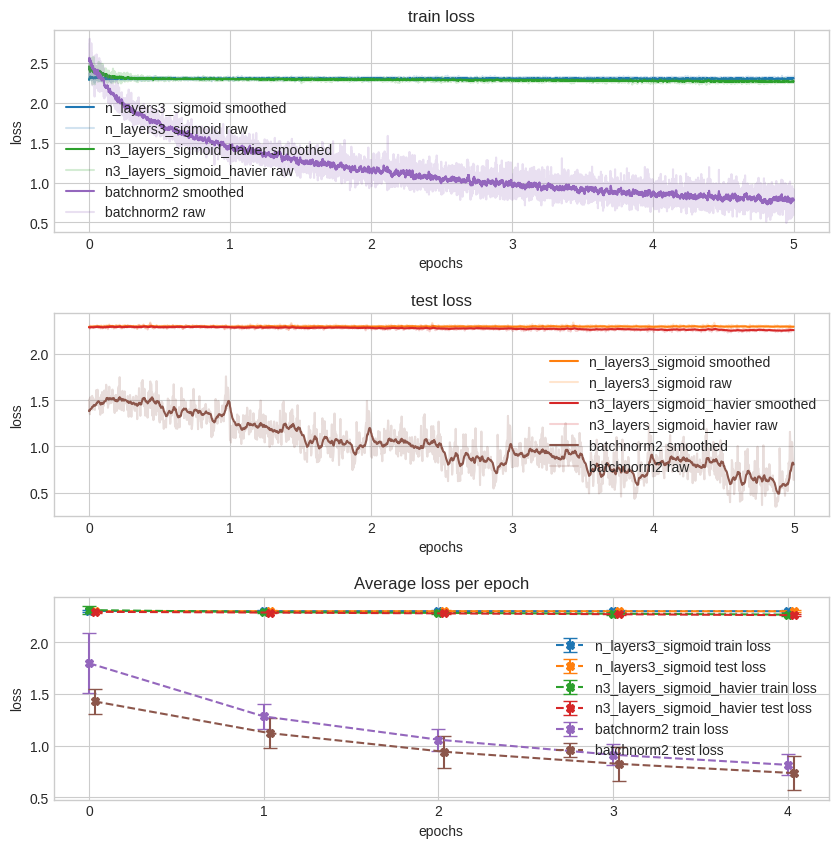

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

Попробуем, согласно советам, увеличить learning rate:

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

model_name = "batchnorm_increased_lr"
hooks_data_history = register_model_hooks(model)
history = train_model_sep(model, optimizer, model_name=model_name)

100%|██████████| 5/5 [01:45<00:00, 21.02s/it]


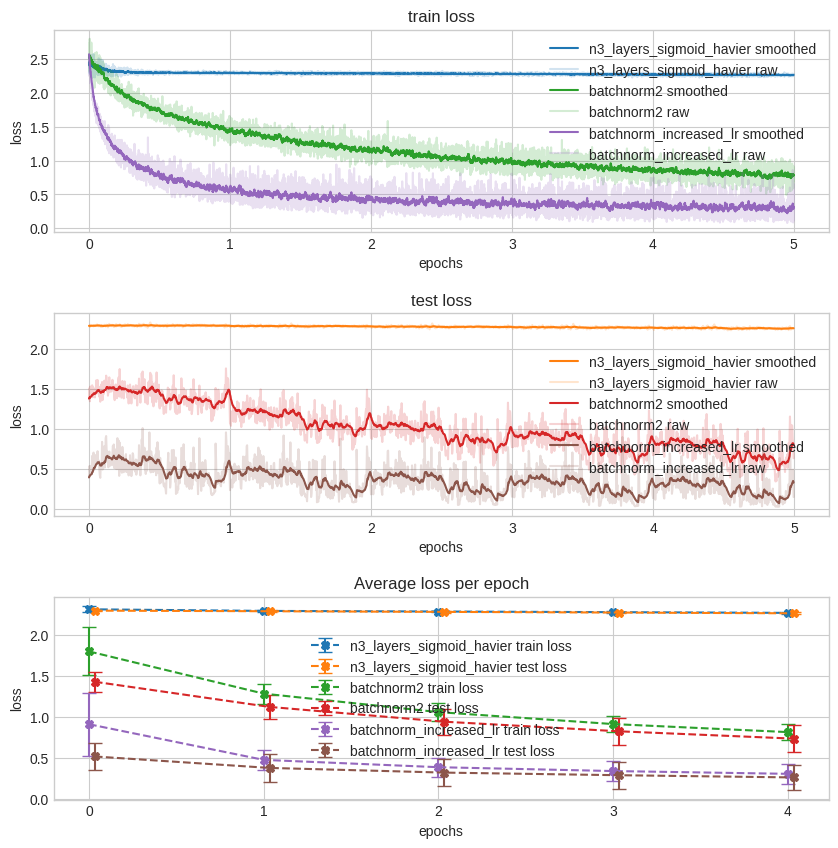

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n3_layers_sigmoid_havier", "batchnorm2", model_name])

### Ставить Batch Normalization до или после активации?



#### До

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnormalization_before_activation.png" width="400">

* **Рекомендуется авторами статьи, где предложили Batch Normalization**.
* Для **сигмоиды** BN, поставленная после активации, **не решает проблем** сигмоиды.
* Во многих сверточных архитектурах, например [**ResNet**](https://arxiv.org/pdf/1512.03385.pdf) и [**MobileNetV2**](https://arxiv.org/pdf/1801.04381.pdf) (изучите на следующих лекциях), Batch Normalization ставится именно так.

#### После

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnormalization_after_activation.png" width="400">

* **Аргументация авторов статьи не до конца обоснована**.
* Обычно, **сигмоиду не используют** в современных нейронных сетях.
* Для популярной **ReLU BN**, поставленная до активации, может приводить к “умирающей **ReLU**”, когда большая часть ее входов меньше 0, и поэтому через них градиент не проходит.
* На многих задачах BN после функции активации **работает лучше** или не хуже поставленной до.

**BN — before or after ReLU?**

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/batchnormalization_before_or_after_relu.png" width="500">

<em>Source: <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">BN experiments</a></em>

**Вывод:** можно экспериментировать с расположением.

## Другие Normalization

Существует большое количество иных нормализаций, их неполный список можно найти [здесь](https://paperswithcode.com/methods/category/normalization). В данной секции мы рассмотрим самые популярные виды нормализации помимо **BatchNorm**.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/normalization_methods.png" width="900">

<center><em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>

### Layer Norm

Помимо свёрточных нейронных сетей, существует специальный тип нейронных сетей, используемых для обработки последовательностей. Называется он "**рекуррентные нейронные сети**", ему будет посвящена следующая лекция.

Когда оказалось, что **BatchNorm** положительно сказывается на обучении нейронных сетей, его попытались применить для различных архитектур. BatchNorm нельзя было использовать "из коробки" для рекуррентных нейронных сетей (работающих с последовательными данными), пришлось придумывать различные адаптации, среди которых наиболее удачной оказалась **Layer Normalization**.

По сути, теперь нормализация происходит внутри **одного объекта из батча**, а не поканально в рамках батча. С математической точки зрения, данная "адаптация" отличается от **BatchNorm**, однако экспериментально она превзошла своих конкурентов в задаче нормализации при обработке последовательных данных.

Впоследствии данный метод нормализации хорошо проявил себя в **трансформерах** — наследниках рекуррентных нейронных сетей в вопросах обработки последовательных данных (об этом типе нейросетей мы также поговорим на следующей лекции). После успешного применения трансформеров в задачах компьютерного зрения, **LayerNorm** стал использоваться и в компьютерном зрении (хотя и уступал BatchNorm при использовании в свёрточных нейронных сетях).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/visualization_of_layer_normalization.png" width="450">

[Layer Normalization](https://paperswithcode.com/method/layer-normalization)


### Instance Norm

Следующий вид нормализации был предложен отечественными исследователями (из Сколтеха), занимавшимися разработкой быстрого и эффективного способа **переноса стиля** с одного изображения на другое.

При использовании BatchNorm теряется информация о контрастах на конкретном изображении, поскольку нормализация производится по нескольким объектам. Для сохранения *контрастов* в экземпляре (*instance*) изображения была предложена специальная нормализация, рассматривающая конкретный канал одного конкретного объекта. Было предложено два названия нормализации: связанное с мотивацией (contrast normalization) и связанное с принципом работы (**instance normalization**).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/visualization_of_instance_normalization.png" width="450">

[Instance Normalization](https://paperswithcode.com/method/instance-normalization)

### Group Norm

В течение долгого времени BatchNorm оставался однозначным фаворитом для использования в задачах компьютерного зрения, однако:
1. В связи с необходимостью точно считать статистики внутри batch, при обучении приходилось использовать большой batch size.  

2. Ограниченность размера памяти видеокарты вынуждает разработчиков идти на компромисс между сложностью модели и размером батча.

Таким образом, использование BatchNorm приводило к невозможности использовать сложные модели**\***, поскольку им просто не хватало места на видеокарте.

Необходимость использовать большой batch size могут решать различные нормализации, не использующие batch-размерность. К примеру, уже известные нам **Layer Norm** и **Instance Norm**. Эмпирически оказалось, что данные нормализации уступают BatchNorm по качеству работы: в то время как LayerNorm предполагает одинаковую важность и суть различных каналов (*рассматривая данные излишне глобально*), InstNorm упускает межканальные взаимодействия (*рассматривая данные слишком локально*).

Успешным обобщением данных методов является **Group Normalization**: данный метод разбивает каналы на $G \in [1; C]$ групп, присваивая каждой из них (примерно) равное количество каналов. Отметим, что при $G = 1$ GroupNorm идентичен LayerNorm, а при $G = C$ GroupNorm идентичен InstanceNorm.

Эмпирически оказалось, что при замене BatchNorm на GroupNorm качество модели падает в разы менее значительно, чем при использовании LayerNorm либо InstanceNorm. Более того, при изменении batch size качество работы GroupNorm не изменялось, что открыло перспективы для создания более сложных моделей компьютерного зрения.

**\*** — подразумевается, что уменьшение batch size позволило бы создать более сложные модели.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/visualization_of_group_normalization.png" width="450">

[Group Normalization](https://paperswithcode.com/method/group-normalization)

# Регуляризация

Второй способ улучшения сходимости нейросетей и борьбы с переобучением — введение регуляризации. Ее можно вводить несколькими способами.

## L1, L2 регуляризации

Мы уже разбирали самый простой способ — добавление штрафа к весам в функцию потерь. На сходимость нейросети это, правда, влияет слабо.

$$Loss\_reg = loss + \lambda \cdot reg$$

$$ reg_{L1} = \lambda \sum |w_i| $$

$$ reg_{L2} = \lambda \sum w_i^2 $$

<img src="https://edunet.kea.su/repo/EduNet-content/L07/out/l1_l2_regularization_to_weight.gif" alt="alttext" width="500"/>

Иногда уже его хватает, чтобы решить все проблемы. Напомним, что **L2** лосс приводит к большому числу маленьких ненулевых весов в сети. А **L1** лосс — к маленькому числу ненулевых весов (разреженной нейросети)

## Dropout

Одним из распространенных именно в нейросетях методом регуляризации является **Dropout**.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/dropout.png" width="700">

Состоит этот метод в следующем:

1. Во время обучения мы с вероятностью $p$ **зануляем выход нейронов** слоя (например, $p = 0.5$)
2. Зануленные нейроны не участвуют в данном `forward`, и поэтому градиент к ним при `backward` не идет.
3. Сила регуляризации определяется вероятностью $p$: чем она больше, тем сильнее регуляризация.

###Сверточные слои

Аналогично **Batch Normalization**, при применении к **сверточному слою**  **Dropout** должен **убирать каналы целиком**. Dropout для полносвязного слоя реализован в PyTorch в [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), для сверточного — в [nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/dropout_2d.png" width="700">

### Мотивация Dropout

#### Борьба с коадаптацией

Одной из  проблем при работе с глубокими сетями является **совместная адаптация нейронов**. Если все весовые коэффициенты обучаются вместе, некоторые соединения будут иметь больше возможностей прогнозирования, чем другие.

**Часть нейронов** делает основную работу — **предсказывает**, а остальные могут вообще не вносить никакого вклада в итоговое предсказание. Или же другая картина: один нейрон делает **неверное предсказание**, другие его **исправляют**, и в итоге первый нейрон свои ошибки не исправляет.

Это явление называется **коадаптацией**. Это нельзя было предотвратить с помощью традиционной регуляризации, такой как **L1** и **L2**. А вот **Dropout** с этим хорошо борется.

Отключая хорошо обученные нейроны, мы заставляем плохо обученные нейроны учиться. Отключая нейроны, которые исправляют ошибки других нейронов, мы заставляем ошибающиеся нейроны исправлять ошибки.

**Dropout** гарантирует, что выучиваемые индивидуальными нейронами функции хорошо работают со **случайно выбранными подмножествами функций**, выученных другими нейронами, улучшая **обобщающую способность** нейронов.

На следующем рисунке, извлеченном из [статьи](https://jmlr.org/papers/v15/srivastava14a.html), мы находим сравнение признаков, изученных в наборе данных **MNIST** нейросетью с **одним скрытым слоем** в автоэнкодере, имеющим 256 признаков после ReLU **без Dropout** (слева), и признаков, изученных той же структурой с использованием **Dropout** в ее скрытом слое с $p = 0.5$ (справа).

Первый показывает неструктурированные, беспорядочные паттерны, которые невозможно интерпретировать. Второй явно демонстрирует целенаправленное распределение весов, которое обнаруживает штрихи, края и пятна самостоятельно, нарушая их взаимозависимость с другими нейронами для выполнения этой работы.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/compare_weights_with_dropout_and_without_dropout.png" width="600"></center>

<center><em>Source: <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">Dropout: A Simple Way to Prevent Neural Networks from
Overfitting</a></em></center>

#### Dropout как регуляризация

Фактически, **Dropout** штрафует слишком сложные, неустойчивые решения. Добавляя в нейросеть **Dropout**, мы сообщаем ей о том, что решение, которое мы ожидаем, должно быть устойчиво к шуму.

#### Dropout как ансамбль

Можно рассматривать **Dropout** как **ансамбль нейросетей** со схожими параметрами, которые мы учим одновременно, вместо того, чтобы учить каждую в отдельности, а затем результат их предсказания усредняем, [выключая Dropout в режиме eval](https://habr.com/ru/companies/wunderfund/articles/330814/).

Таким образом, возникает аналогия со случайным лесом: каждая из наших нейросетей легко выучивает выборку и переобучается — имеет низкий bias, но высокий variance. При этом, за счет временного отключения активаций, каждая нейросеть видит не все объекты, а только часть. Усредняя все эти предсказания, мы уменьшаем variance.



#### Dropout помогает бороться с переобучением

Dropout, в силу указанного выше, может хорошо помогать бороться с переобучением.

И в случае линейных слоев

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/dropout_solve_overfitting_problem_in_mlp_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em>

И в случае свёрточных слоёв

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/dropout_solve_overfitting_problem_in_convolution_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em>

#### Простая реализация Dropout

Напишем "наивную" реализацию модуля Dropout.

**Замечание:** Этот блок кода дан для объяснения работы Dropout, при построении нейронной сети используйте [`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) или [`nn.Dropout2d`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

In [ ]:
class BadDropout(nn.Module):
    def __init__(self, p: float = 0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep
        # in test time, expectation is calculated
        return x * (1 - self.p)

Приведенная реализация неоптимальна, так как в режиме инференса (когда ```training = False```) функция ```forward``` совершает дополнительное умножение. Одним из приоритетов при создании модели является скорость работы в режиме инференса. Поэтому по возможности все "лишние" операции выполняют только в режиме обучения. В данном случае можно целиком убрать коэффициент нормировки из режима инференса, перенеся его в режим обучения в знаменатель.

Дополнительным плюсом такого подхода является то, что при удалении модуля из архитектуры сети функция прогнозирования не изменится.

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p: float = 0.2):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep / (1 - self.p)
        return x  # in test time, expectation is calculated intrinsically - we just not divide weights

Попробуем применить Dropout в нашей нейросети:

In [ ]:
class SimpleMNIST_NN_Dropout(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid, init_form="normal"):
        super().__init__()
        self.n_layers = n_layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100))
            layers.append(Dropout())  # add Dropout
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("sigmoid")
        for child in self.layers.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight, gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight, gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

Так как наша модель из-за Dropout ведет себя по-разному во время обучения и во время тестирования, мы должны прямо ей сообщать, обучается она сейчас или нет. Используем `train_model_sep`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Активируются Dropout слои.}}&\large{\text{Слои Dropout отключены.}}\\
\large{\text{Выход части нейронов обнуляется, выходы нормируются.}}&\large{\text{Все нейроны работают.}}
\end{array}
$$



Обучим модель с **Dropout**:

In [ ]:
model = SimpleMNIST_NN_Dropout(n_layers=3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

model_name = "nn3_dropout"
history = train_model_sep(model, optimizer, model_name=model_name)

100%|██████████| 5/5 [01:35<00:00, 19.10s/it]


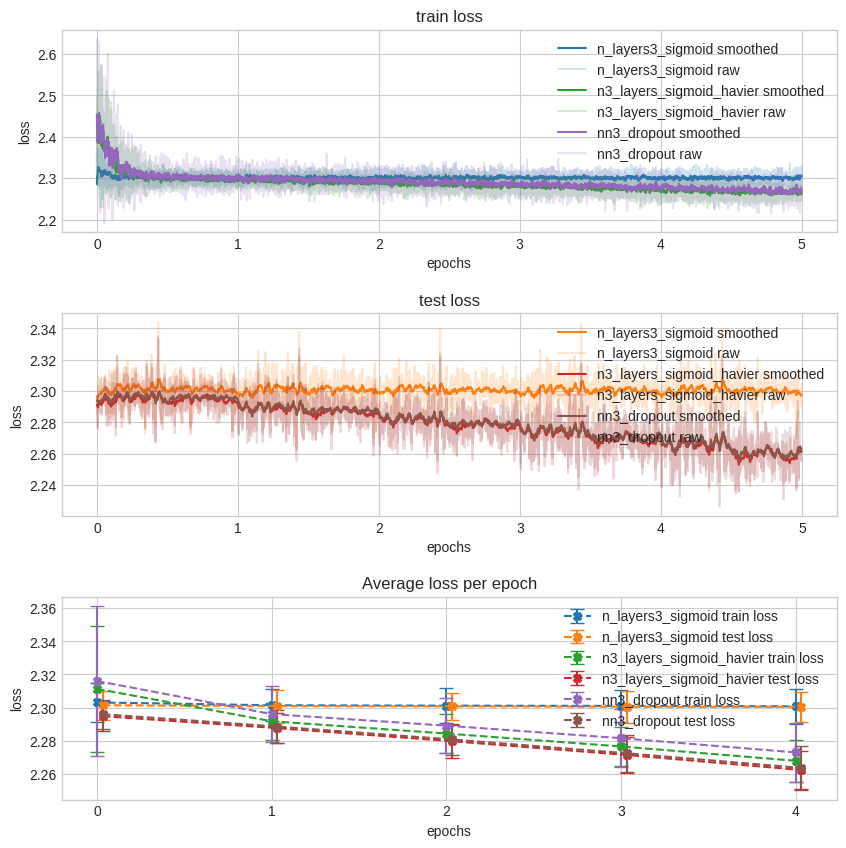

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

В данном случае выигрыша мы не получили. Возможно, если учить нейросеть больше эпох, эффект бы заметили

#### Пример борьбы с переобучением при помощи Dropout


Чтобы увидеть эффект и при этом не учить нейросеть 100+ эпох, сделаем искусственный пример.

Просто **добавим к линейной зависимости шум** и попробуем выучить ее нейронной сетью.

[Dropout in Neural Networks with PyTorch (перевод)](https://machinelearningmastery.ru/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd/#).

In [ ]:
N = 50  # number of data points
noise = 0.3

# generate the train data
x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

# generate the test data
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

print(f"x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}")

x_train shape: torch.Size([50, 1])
x_test shape: torch.Size([50, 1])


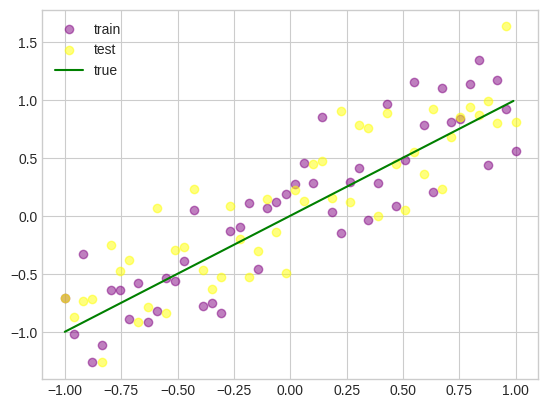

In [ ]:
plt.scatter(
    x_train.data.numpy(), y_train.data.numpy(), c="purple", alpha=0.5, label="train"
)
plt.scatter(
    x_test.data.numpy(), y_test.data.numpy(), c="yellow", alpha=0.5, label="test"
)

x_real = np.arange(-1, 1, 0.01)
y_real = x_real
plt.plot(x_real, y_real, c="green", label="true")
plt.legend()
plt.show()

Модель **без Dropout**:

In [ ]:
N_h = 100  # num of neurons
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Модель **с Dropout**:

In [ ]:
N_h = 100  # num of neurons

model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5),  # 50 % probability
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    nn.Dropout(0.2),  # 20% probability
    nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)

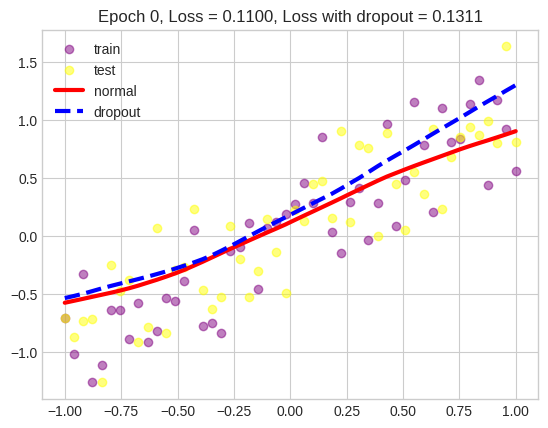

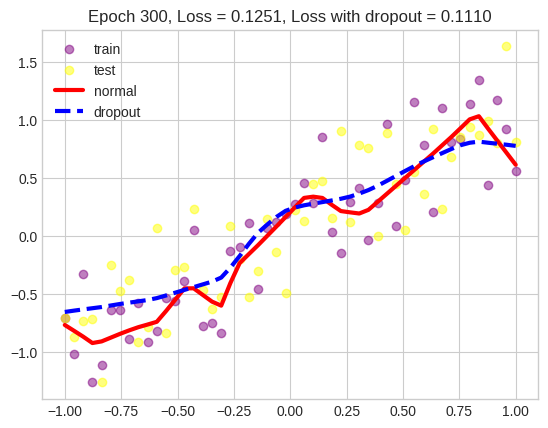

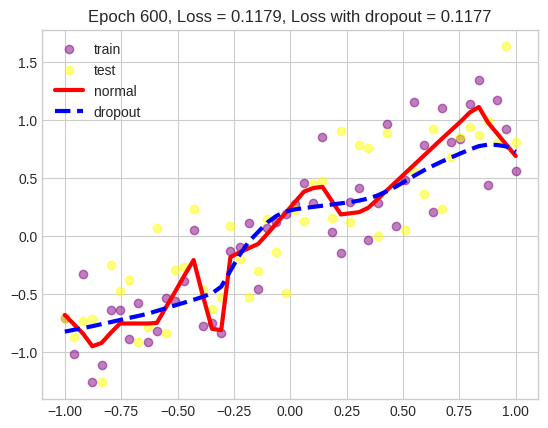

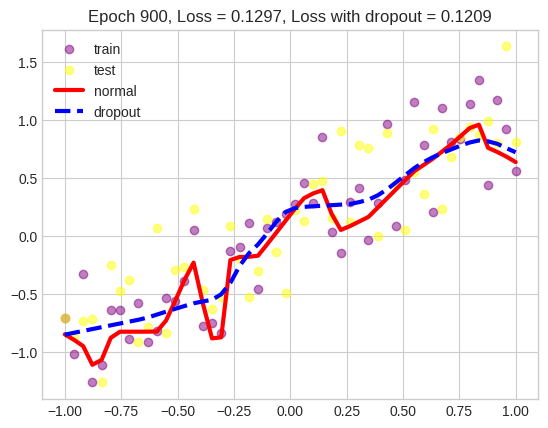

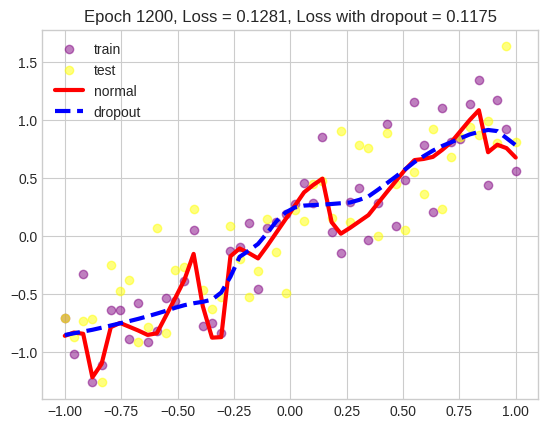

In [ ]:
num_epochs = 1500
criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):
    # train without dropout
    y_pred = model(x_train)  # look at the entire data in a single shot
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # train with dropout
    y_pred_dropout = model_dropout(x_train)
    loss_dropout = criterion(y_pred_dropout, y_train)
    optimizer_dropout.zero_grad()
    loss_dropout.backward()
    optimizer_dropout.step()

    if epoch % 300 == 0:
        model.eval()  # not train mode
        model_dropout.eval()  #  not train mode

        # get predictions
        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test)

        y_test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = criterion(y_test_pred_dropout, y_test)
        # plotting data and predictions
        plt.scatter(
            x_train.data.numpy(),
            y_train.data.numpy(),
            c="purple",
            alpha=0.5,
            label="train",
        )
        plt.scatter(
            x_test.data.numpy(),
            y_test.data.numpy(),
            c="yellow",
            alpha=0.5,
            label="test",
        )
        plt.plot(
            x_test.data.numpy(), y_test_pred.data.numpy(), "r-", lw=3, label="normal"
        )
        plt.plot(
            x_test.data.numpy(),
            y_test_pred_dropout.data.numpy(),
            "b--",
            lw=3,
            label="dropout",
        )

        plt.title(
            "Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f"
            % (epoch, test_loss, test_loss_dropout)
        )

        plt.legend()

        model.train()  # train mode
        model_dropout.train()  # train mode

        plt.pause(0.05)

Видим, что **нейросеть без Dropout сильно переобучилась**.

#### Доверительный интервал от Dropout

Можно, используя нейросеть с Dropout, получить **доверительный интервал** для нашего предсказания (как делали в лекции по ML). Просто **не "замораживаем" dropout-слои** во время предсказания, а делаем предсказания с активными dropout.

Делаем предсказание для каждого объекта 1000 раз. Сделав это 1000 раз, вы получаете распределение предсказаний, на основе которого можно делать **доверительные интервалы** и как раз ловить **аномалии** — те объекты, на которых нейросеть вообще не понимает, что ей делать, и потому предсказывает метку или еще что-то с сильной дисперсией.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/confidence_interval_dropout.png" width="600"></center>

<center><em>Source: <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week14/14-3/">Overfitting and regularization</a></em></center>



## DropConnect

Если занулять не нейроны (активации), а случайные веса с вероятностью $p$, получится DropConnect.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/dropconnect.png" width="650">

DropConnect похож на Dropout, поскольку он вводит динамическую разреженность в модель, но отличается тем, что разреженность зависит от весов *W*, а не от выходных векторов слоя. Другими словами, полностью связанный слой с DropConnect становится разреженно связанным слоем, в котором соединения выбираются случайным образом на этапе обучения.

В принципе, вариантов зануления чего-то в нейронной сети можно предложить великое множество, в разных ситуациях будут работать разные способы ([в этом списке](https://paperswithcode.com/methods/category/regularization)  много Drop...).

## DropBlock

Например, можно убирать для каждого батча из нейросети случайные блоки из слоев. И это будет работать!

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/dropblock.png" width="750">

[Deep Networks with Stochastic Depth (Huang et al., 2016)](https://arxiv.org/pdf/1603.09382.pdf)

## Batch Normalization до или после Dropout



### После

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnormalization_after_dropout.png" width="600">

* **Плохо**: В режиме обучения **Dropout** будет отключать (занулять) выходы слоя активации, из-за этого накопленные в режиме обучения **значения скользящего среднего матожидания и дисперсии** для вычисления **Batch Normalization** в режиме тестирования будут иметь **сдвиг**, который приведет к нестабильной работе нейросети.


Подробно об этом можно почитать в [статье](https://arxiv.org/pdf/1801.05134.pdf) и [блокноте](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb).

### До

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/batchnormalization_before_dropout.png" width="600">

* **Лучше**: Меньше влияние сдвига от **Dropout** на **BatchNorm**. Но если на предыдущих слоях есть **Dropout**, то значения все равно могут быть смещены.  

### Ставить только что-то одно

* **Dropout** может отрицательно влиять на качество нейросети с **BatchNorm** за счет разного поведения на train и test. Лучше не ставить **Dropout** раньше **BatchNorm**.

### Строго говоря

* Оптимальный порядок следования слоев зависит от задачи и архитектуры сети.
* Возможно, стоит применять другие виды нормализации.
* Если используем **BatchNormalization**, то надо уменьшить силу **Dropout** и **L2**-регуляризации.

# Оптимизация параметров нейросетей

В процессе обучения мы пытаемся подобрать параметры модели, при которых она будет работать лучше всего. Это — **оптимизационная задача** (задача подбора оптимальных параметров). Мы уже ознакомились с одним алгоритмом оптимизации параметров — **градиентным спуском**.

Существует множество **алгоритмов оптимизации**, которые можно применять для поиска минимума функционала ошибки ([неполный список](https://paperswithcode.com/methods/category/stochastic-optimization)). Эти алгоритмы реализованы в модуле [`torch.optim`](https://pytorch.org/docs/stable/optim.html).

Важно отметить, что **выбор оптимизатора не влияет на расчет градиента**. Градиент в PyTorch вычисляется автоматически на основе графа вычислений.


## Обзор популярных оптимизаторов

### SGD (stochastic gradient descent)

При градиентном спуске мы:
- делаем **прямой проход**, вычисляем функционал ошибки $L(x, y, w_t)$;
- делаем **обратный проход**, вычисляем градиент $\nabla_wL(x, y, w_t)$;
- делаем **шаг оптимизации**: изменяем параметры модели по формуле:

$$w_{t+1} = w_t - lr \cdot \nabla_wL(x, y, w_t),$$

домножая антиградиент на постоянный коэффициент $lr$ (гиперпараметр обучения — learning rate).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/stochastic_gradient_descent.gif" width="950">

У данного алгоритма есть проблема: он может застревать в **локальных минимумах** или даже **седловых точках**.

**Cедловые точки** — точки, в которых все производные равны 0, но они не являются экстремумами. В них градиент равен 0, веса не обновляются — оптимизация останавливается.

Пример таких точек:

- точка $(0, 0)$ у функции $y = x^3$, не имеющей минимума или максимума вовсе;
- точка $(0, 0, 0)$ у функции $z = x^2 - y^2$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/getting_stuck_in_local_minimum_example.png" width="350"> <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/saddle_point_example.png" width="400"></center>

<center><em><a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B4%D0%BB%D0%BE%D0%B2%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BA%D0%B0">Седловая точка</a></em></center>

Частично эту проблему решает **стохастический градиентный спуск** (stochastic gradient descent, **SGD**). В нем для градиентного спуска используется не все данные, а некоторая подвыборка (mini-batch) или даже один элемент.


**SGD** обладает важной особенностью: на каждом объекте или подвыборке (mini-batch) ландшафт функции потерь выглядит по-разному. Некоторые минимумы функции потерь и седловые точки могут быть характерны лишь для части объектов.

Ниже **упрощенно** показаны ландшафты функции потерь на полном датасете и на отдельных батчах. При оптимизации на полном датасете модель могла бы **остановиться в левом локальном минимуме**, но стохастическая природа спуска позволяет избежать этого за счет того, что **для некоторых батчей этот минимум отсутствует**.

В результате модель сможет остановиться только в каком-то относительно широком и глубоком минимуме, характерном для большинства батчей обучающих данных. С большой вероятностью этот минимум будет присутствовать и на реальных данных, то есть модель сможет адекватно работать с ними.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/sgd_loss_batch_landscape.png" width="700">

**SGD** до сих пор является достаточно популярным методом обучения нейросетей, потому что он простой, не требует подбора дополнительных гиперпараметров, кроме **скорости обучения** `lr`, и сам по себе обычно дает неплохие результаты.

Если же модель учится слишком долго и/или важна каждая сотая в качестве, то нужно либо использовать его в совокупности с другими техниками (их рассмотрим далее), либо использовать другие способы.

Фрагмент кода для понимания работы SGD:
```
class SGD:  
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr
  
  def step(self):
    d_parameters = self.parameters.grad
    self.parameters -= self.lr*d_parameters
```

Алгоритм SGD реализован в [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [ ]:
import torch.optim as optim

parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001)

**Минусы SGD**:

 1. Если функция ошибки быстро меняется в одном направлении, а в другом &mdash; медленно, то это приводит к резким изменениям направления градиентов и замедляет процесс обучения.


<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500">


 2. Может застревать в локальных минимумах или седловых точках.

 3. Мы оцениваем градиент по малым частям выборки, которые могут плохо отображать градиент по всей выборке и являться шумными. В результате часть шагов градиентного спуска делается впустую или во вред.

 4. Мы применяем один и тот же `learning rate` ко всем параметрам, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных.

 5. Просто медленнее сходится.

**SGD** является основой всех описанных ниже алгоритмов.

### Momentum

Чтобы избежать проблем 1–3, можно добавить движению по ландшафту функции ошибок инерции (**momentum**). По аналогии с реальной жизнью: если мяч катится с горки, то он благодаря инерции может проскочить пологое место или даже небольшую яму.  

Корректируем направление движения шарика с учетом текущего градиента:

$$v_{t} = m \cdot v_{t-1} + \nabla_wL(x, y, w_{t})$$

где $m \in [0, 1)$ — momentum (гиперпараметр).

Вычисляем, куда он покатится:

$$w_{t+1} = w_t - lr \cdot v_{t}$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/advantages_wtih_momentum.png" width="480">

[Градиентный спуск, как учатся нейронные сети (видео)](https://youtu.be/IHZwWFHWa-w)

Теперь мы быстрее достигаем локального минимума и можем выкатываться из совсем неглубоких. Градиент стал менее подвержен шуму, меньше осциллирует

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"> <img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/stohastic_gradient_descent_with_momentum.gif" width="500">

Фрагмент кода для понимания работы Momentum:

```
class SGD_with_momentum:  
  def __init__(self, parameters, momentum, lr):
    self.parameters = parameters
    self.momentum = momentum
    self.lr = lr
    self.velocity = torch.zeros_like(parameters)
    
  def step(self):
    d_parameters = self.parameters.grad
    self.velocity =  self.momentum*self.velocity + d_parameters
    self.weights -= self.lr*self.velocity
```


**Momentum удваивает количество хранимых параметров.**

Алгоритм Momentum реализован в [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)

У этого подхода есть одна опасность — мы можем выкатиться за пределы минимума, к которому стремимся, а потом какое-то время к нему возвращаться.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/problem_of_big_momentum_value.gif" width="700">

<em>Source: <a href="https://distill.pub/2017/momentum/">Why Momentum Really Works</a></em>

[optimizer-visualization](https://github.com/Jaewan-Yun/optimizer-visualization)

Чтобы с этим бороться, предложен другой способ подсчета инерции

### NAG (Nesterov momentum)

Будем сначала смещаться в сторону, куда привел бы нас наш накопленный градиент, там считать новый градиент и смещаться по нему.
В результате перескоки через минимум будут менее значительными, и алгоритм будет быстрее сходиться:

$$v_{t} = m \cdot v_{t-1} +  \nabla_w L(w_t - lr \cdot m \cdot  v_{t-1} )$$

$$w_{t+1} = w_{t} - lr \cdot v_{t} $$

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/nesterov_momentum.png" width="800">

Кажется, что для реализации такого алгоритма необходимо пересчитывать прямой и обратный проход с новыми параметрами, для вычисления градиента. На практике эту формулу можно [переписать](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf) так, чтобы не пересчитывать градиент.

С псевдокодом, описывающим последовательность действий NAG, можно познакомиться в [документации PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

**Так же, как momentum, Nesterov momentum удваивает количество хранимых параметров.**

Алгоритм Nesterov momentum реализован в [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=0.001)

### Adaptive Learning Rate

Описанные алгоритмы не борются с 4-ой проблемой SGD: "мы применяем **один и тот же learning rate ко всем параметрам**, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных".

**Пример:** мы решаем задачу классификации картинок из Интернета, и у нас есть параметры, ответственные за признаки, которые характеризуют кошек породы сфинкс. Кошки породы сфинкс встречаются в нашем датасете редко, и эти параметры реже получают информацию для обновления. Поэтому наша модель может хуже классифицировать кошек этой породы.

Для решения этой проблемы мы можем завести для каждого параметра **индивидуальный learning rate**, зависящий от того, как часто и как сильно изменяется этот параметр в процессе обучения.

### Adagrad

Будем хранить для каждого параметра **сумму квадратов его градиентов** (запоминаем, как часто и как сильно он изменялся).

И будем вычитать из значений параметров градиент с коэффициентом, обратно пропорциональным корню из этой суммы $G_t$.

$$ G_ t = \sum_{i=1}^t \nabla_w L(x,y,w_i)\odot\nabla_w L(x,y,w_i) $$

$$ w_{t+1} = w_{t} -  \frac{lr}{\sqrt{G_t} + e} \odot \nabla_w L(x,y,w_{t}) $$

$e$ — малая константа, чтобы не допускать деления на ноль, $\odot$ — поэлементное умножение.

В результате, если градиент у нашего веса часто большой, коэффициент будет уменьшаться.

Проблема заключается в том, что при такой формуле наш `learning rate` неминуемо в конце концов затухает (так как сумма квадратов не убывает).


Фрагмент кода для понимания работы Adagrad:
```
class AdaGrad:  
  def __init__(self, parameters, lr=0.01):
     self.parameters = parameters
     self.lr = lr
     self.grad_squared = torch.zeros_like(parameters)
   
  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared += d_parameters*d_parameters
    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adagrad удваивает количество хранимых параметров**

Алгоритм Adagrad реализован в [`torch.optim.Adagrad`](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

### RMSprop

Добавим "забывание" предыдущих квадратов градиентов. Теперь мы считаем не сумму квадратов, а [экспоненциальное скользящее среднее](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) с коэффициентом $\alpha$.


$$G_t = \alpha \cdot G_{t-1} + (1-\alpha) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t)$$

$$w_{t+1} = w_{t} - \frac{lr}{\sqrt{G_t }+ e} \odot \nabla_w L(x,y,w_t)$$

Фрагмент кода для понимания работы RMSprop:

```
class RMSprop():  
  def __init__(self, parameters, lr=0.01, alpha=0.99):
    self.parameters = parameters
    self.lr = lr
    self.alpha = alpha
    self.grad_squared = torch.zeros_like(parameters)
  
  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared = self.alpha*self.grad_squared + \
        (1 - self.alpha)*d_parameters*d_parameters

    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Так же, как Adagrad, RMSprop удваивает количество хранимых параметров**

Алгоритм RMSprop реализован в [`torch.optim.RMSprop`](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html).

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

### Adam

Одним из самых популярных адаптивных оптимизаторов является Adam, объединяющий идеи momentum и adaptive learning rate:

$$ v_t = \beta_1 \cdot v_{t-1} + (1-\beta_1) \cdot \nabla_w L(x,y,w_t) $$

$$ G_t = \beta_2 \cdot G_{t-1} + (1-\beta_2) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t) $$

$$ w_{t+1} = w_t - \frac{lr}{\sqrt{G_t} + e} \odot v_t$$

где $\beta_1$ — аналог $m$ из Momentum, а $\beta_2$ — аналог $\alpha$ из RMSprop.

Фрагмент кода для понимания работы Adam:

```
class Adam:  
  def __init__(self, parameters, lr=0.01, betas=(0.9, 0.999)):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.grad_squared = torch.zeros_like(parameters)   
    self.beta_1 = betas[0] # momentum
    self.beta_2 = betas[1] # alpha
  
  def step(self):
    d_parameters = self.parameters.grad
    # momentum
    self.velocity = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # adaptive learning rate
    self.grad_squared = self.beta_2*self.grad_squared + \
        (1 - self.beta_2)*d_parameters*d_parameters
    self.parameters -= self.lr*self.velocity / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adam утраивает количество хранимых параметров**

Чтобы в начале у нас получались очень большие шаги, будем дополнительно модицифировать инерцию и сумму квадратов:

$$ v_t = \frac{v_t}{1-\beta_1^t} $$

$$ G_t = \frac{G_t}{1-\beta_2^t} $$

Алгоритм Adam реализован в [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adam([parameters], betas=(0.9, 0.999))

Пример применения

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
hooks_data_history = register_model_hooks(model)

model_name = "adam"
history = train_model_sep(model, optimizer, model_name="adam")

100%|██████████| 5/5 [01:47<00:00, 21.59s/it]


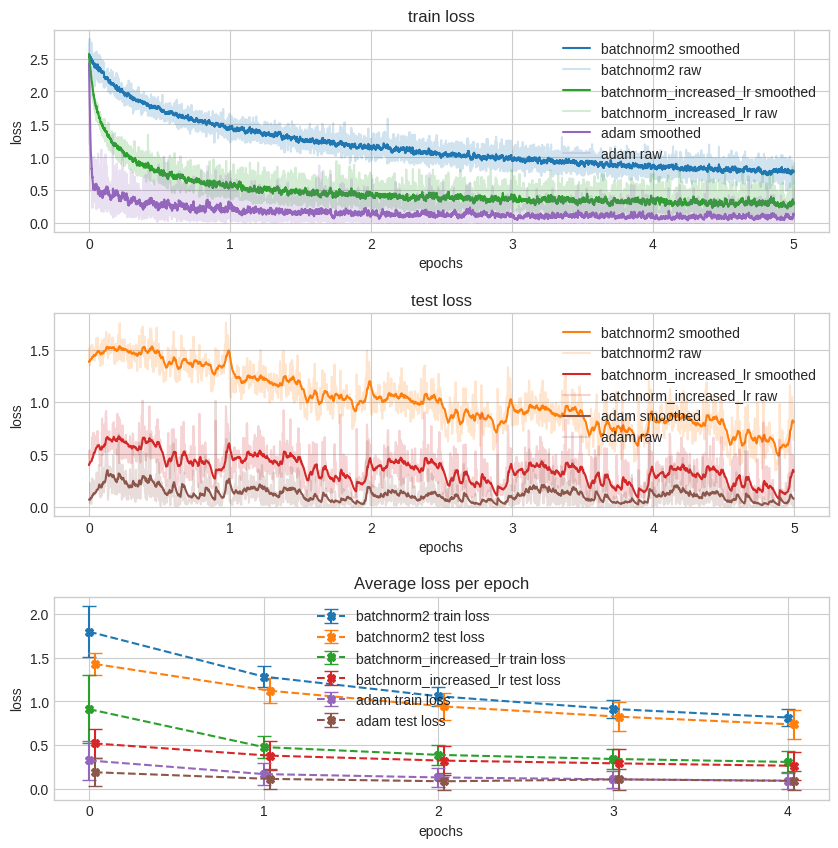

In [ ]:
history_plotter.add(history)
history_plotter.plot(["batchnorm2", "batchnorm_increased_lr", model_name])

### L2 vs Weight decay

Для использования L2 c оптимизатором необходимо указать значение `weight_decay`,  где `weight_decay` — коэффициент перед L2.

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop(model.parameters(), alpha=0.99, weight_decay=0.001)

Вообще говоря, **Weight decay** и **L2** — это немного разные вещи.

**L2** добавляет член регуляризации к Loss функции:

$$Loss_{L2} = Loss + \frac{λ}{2n}w^2$$

**Weight decay** уменьшает веса:

$$w_{wd} = w - \frac{λ}{n}w$$

где $λ$ — константа, а $n$ — количество элементов в батче.


Для **SGD** оптимизатора **Weight decay** и **L2** **эквивалентны**, но не для всех оптимизаторов это так.

Например, это не так для **Adam**. **L2** регуляризация прибавляется к Loss функции и изменяет **значение градиента**, квадраты которого будут храниться. **Weight decay** изменяет только веса (подробно об этом можно почитать [тут](https://arxiv.org/pdf/1711.05101.pdf)).

**Обратите внимание**, что `weight_decay` в `torch.optim.Adam` — это **коэффициент перед L2**. **Weight decay** для **Adam** реализовано в
`torch.optim.AdamW`.

Считается, что **Weight decay** для **Adam** работает лучше, чем **L2**, но на практике это не всегда выполняется.


### Другие оптимизаторы (Lion)

Не Adam-ом единым живут нейронные сети. Есть альтернативные методы оптимизации, например, проект [Google Brain](https://research.google/teams/brain/) в 2023 году опубликовал [статью](https://arxiv.org/pdf/2302.06675.pdf), в которой описывает найденный в процессе [AutoML](https://arxiv.org/pdf/2101.08809.pdf) (автоматического подбора архитектур и алгоритмов) оптимизатор, названный **Lion**  (Evo**L**ved S**i**gn M**o**me**n**tum) 🦁.

Интересно, что AutoML алгоритм пришел к интуитивно понятной эвристике: градиенты — вещь не очень надежная. Они могут взрываться и затухать. Может тогда мы зафиксируем размер шага, а градиенты будем использовать только для определения направления?

Для определения направления используют функцию $sign$ (знак):

\begin{align}
\text{sign}(x) = \left\{
\begin{array}{cl}
1 & x > 0 \\
0 & x = 0\\
-1 & x < 0.
\end{array}
\right.
\end{align}


К этому добавляется уже изученный нами momentum, чтобы знак “прыгал” реже. Интересно, что AutoML подобрал алгоритм, в котором используются две константы для momentum. $\beta_1$ — для определения текущего знака градиента, $\beta_2$ — для хранения значения $v_t$. Значения по умолчанию $\beta_1 = 0.9$, $\beta_2 = 0.99$. Это значит, что текущее значение градиента сильнее влияет на значение для выбора направления текущего шага $с_{t}$, чем на хранимое значение момента $v_t$.


Значение для вычисления направления текущего шага:

$$с_{t} = \beta_1 \cdot v_{t-1} + (1-\beta_1) \nabla_wL(x, y, w_{t})$$

Шаг оптимизатора. $λ$ — константа weight decay:

$$w_{t+1} = w_t - lr \cdot (sign(c_t) +λ w_t)$$

Обновление хранимого значения момента:

$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \nabla_wL(x, y, w_{t})$$

Фрагмент кода для понимания работы **Lion**:

```
class Lion:  
  def __init__(self, parameters, lr=0.0001, betas=(0.9, 0.99), weight_decay=0.01):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum 1
    self.beta_2 = betas[1] # momentum 2
    self.weight_decay = weight_decay
  
  def step(self):
    d_parameters = self.parameters.grad
    # current momentum
    current = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # step
    self.parameters -= self.lr*(torch.sign(carent)+self.weight_decay*self.parameters)
    # history momentum
    self.velocity = self.beta_2*self.velocity + (1 - self.beta_2)*d_parameters
```

**Lion удваивает количество хранимых параметров**

Обратите внимание, что значение lr по умолчанию у **Lion** выбрано меньше, чем у **Adam**. Это связано с тем, что только lr и регуляризация определяют размер шага. Авторы статьи советуют брать для **Lion** в 10 раз меньший lr, чем для **Adam**.

У **Lion** есть преимущества по сравнению с **Adam** и **AdamW**: в нем нет необходимости хранить квадраты градиентов. Он позволяет **снизить количество хранимых параметров** в 1.5–2 раза по сравнению с **AdamW**, а также сокращает количество операций, что позволяет [ускорить расчеты на 2-15%](https://arxiv.org/pdf/2302.06675.pdf) (в Colab это не заметно из-за специфики, связанной с виртуальными машинами).

Кроме того, **Lion** [позволяет добиться лучших результатов](https://github.com/google/automl/tree/master/lion), чем AdamW, при обучении больших сложных моделей, таких как Visual Transformer-ы и диффузионные модели.

Но до сложных моделей мы пока не добрались, попробуем простую. Воспользуемся реализацией [lion-pytorch](https://github.com/lucidrains/lion-pytorch)

In [ ]:
!pip install -q lion-pytorch

In [ ]:
from lion_pytorch import Lion

model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)

model_name = "lion"
history = train_model_sep(model, optimizer, model_name="lion", num_epochs=5)

100%|██████████| 5/5 [01:45<00:00, 21.13s/it]


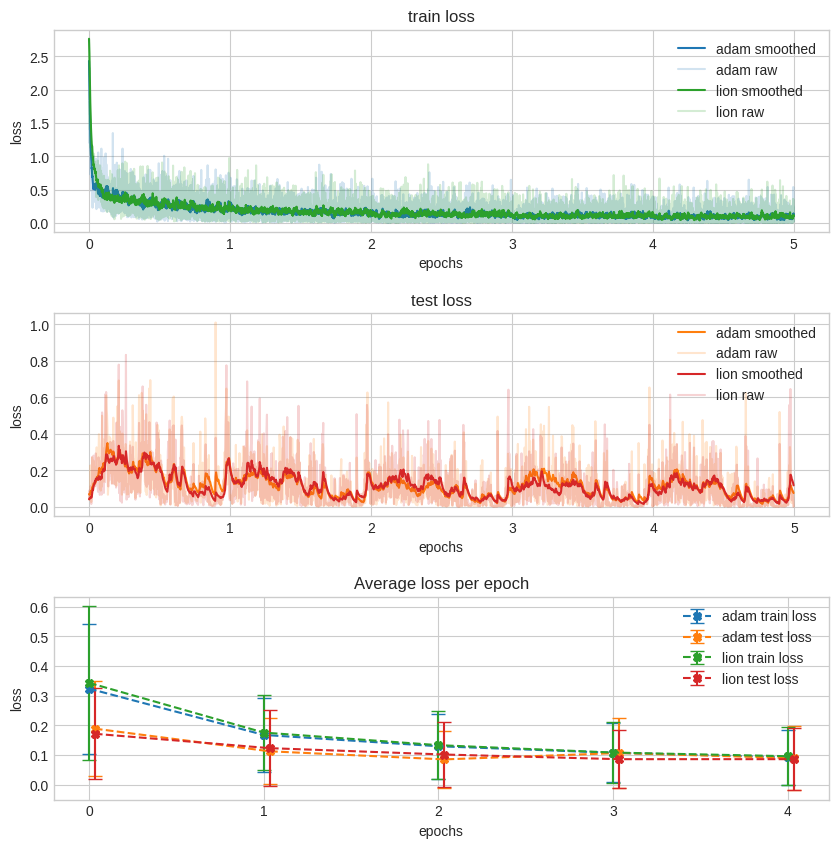

In [ ]:
history_plotter.add(history)
history_plotter.plot(["adam", model_name])

Результат получился почти как у **Adam**, число хранимых параметров меньше.



## Ландшафт функции потерь


Существует [исследование](https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf), которое показывает, что ландшафт функции потерь представляет собой неизолированные локальные минимумы (рисунок слева), а связанные области с почти постоянным значением (рисунок справа). Поэтому умение “выбираться” из седловых точек важно.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/loss_surfaces.png" width="900"></center>

<center><em>Source: <a href="https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf">Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs</a></em></center>

## Сравнение оптимизаторов

У каждого из предложенных оптимизаторов есть минусы и плюсы

- Методы с инерцией сходятся к решению более плавно, но могут "перелетать"

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/convergence_optimizers.gif" width="250">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em>



* Методы с адаптивным learning rate быстрее сходятся, более стабильны и меньше случайно блуждают

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/methods_with_adaptive_learning_rate.gif" width="250">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em>


* Алгоритмы без адаптивного learning rate сложнее выбираются из локальных минимумов

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/methods_without_adaptive_learning_rate.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em>

* Алгоритмы с инерцией осцилируют в седловых точках прежде, чем находят верный путь

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/methods_with_momentum_in_saddle_point.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em>


# Режимы обучения

Нам не обязательно поддерживать один и тот же `learning rate` в течение всего обучения. Более того, для того же SGD есть гарантии, что если правильно подобрать схему уменьшения `learning rate`, он сойдется к глобальному оптимуму.

Мы можем менять `learning rate` по некоторым правилам.  

## Ранняя остановка

Можем использовать критерий ранней остановки: когда значение функции потерь на валидационной выборке не улучшается какое-то количество эпох(`patience`), умножаем `learning rate` на некое значение `factor`).

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/early_stopping.png" width="500">

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=5
)

Применим к нашей модели

(выполнение занимает ~ 5 минут)

In [ ]:
def train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=None, num_epochs=5
):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        scheduler.step(val_loss)
    return train_history

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=1
)

model_name = "reduce_lr_on_plateu"
hooks_data_history = register_model_hooks(model)
history = train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)

100%|██████████| 5/5 [01:48<00:00, 21.63s/it]


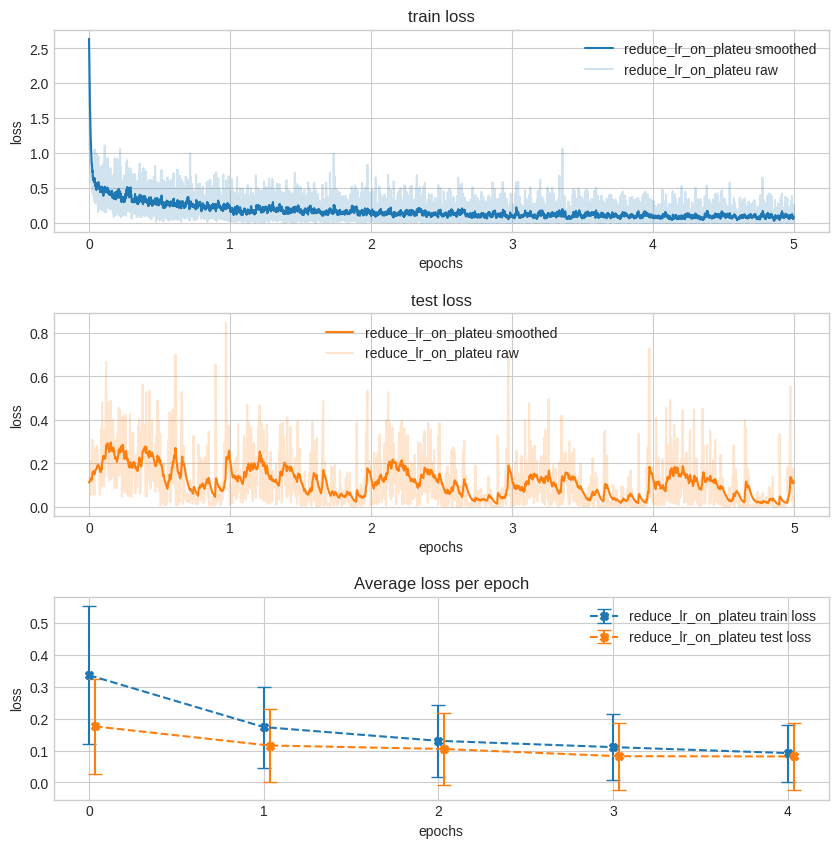

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

## Понижение шага обучения на каждой эпохе

Домножать `learning rate` на `gamma` каждую эпоху

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

## Neural Network WarmUp

Для достаточно больших нейронных сетей практикуют следующую схему (**gradual warmup**, [изначальная статья](https://arxiv.org/pdf/1706.02677.pdf)):

1. Поставить изначальный `learning rate` значительно ниже того, с которого мы обычно начинаем обучение.
2. За несколько эпох, например, 5, довести `learning rate` от этого значения до требуемого. Так мы не совершаем больших шагов, когда сеть еще ничего не знает о данных. За счет этого нейросеть лучше "адаптируется" к нашим данным.

Также такой `learning schedule` позволяет адаптивным оптимизаторам лучше оценить значения `learning rate` для разных параметров

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/neural_network_warmup.png" width="1000"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.02677.pdf">Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour</a></em></center>


$kn$ на картинке — это размер одного батча.

## Cyclical learning schedule


Статья: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf)

**Идея:**
Функция потерь может иметь сложный ландшафт. Нам бы хотелось:
* Изучить побольше локальных минимумов.
* Оценить качество в каждом локальном минимуме.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/Cyclic_LR_Schedule.png" width="750"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Для этого мы можем не все время понижать learning rate, а делать это **циклически**: то понижать, то повышать.

При **увеличении** learning rate модель может **выбраться** из одного локального минимума. При **уменьшении** — **сойтись** к следующему.


Есть две основные мотивации использования **циклического learning rate**:

* **Ускорение сходимости**: мы уже посмотрели на адаптивные оптимизаторы. Их недостатком является необходимость хранения в памяти квадратов градиентов. Для циклического learning rate это необязательно, его можно использовать с SGD, изменяя скорости в 3–4 раза. Аналогично с Adam — это позволит редким признакам быстрее обучаться (частые признаки будут немного “ломаться”, а затем восстанавливаться). Для таких целей важно подбирать learning rate вблизи оптимального. Идея этого представлена в [статье](https://arxiv.org/pdf/1506.01186.pdf).

* **Создание ансамблей моделей:** разные локальные минимумы будут давать ошибки на разных объектах. Можно сохранять модели в локальных минимумах и не только искать лучшую, но и устраивать между моделями голосования. Для этого learning rate изменяют в сотни раз. Идея этого представлена в [статье](https://openreview.net/pdf?id=BJYwwY9ll). Обычно для создания ансамблей используют [циклический отжиг](https://arxiv.org/pdf/1608.03983.pdf).


 ### Ускорение сходимости

Циклическое изменение  learning rate для ускорения сходимости реализовано в PyTorch в `optim.lr_scheduler.CyclicLR`.

Делать это можно по-разному (`mode` — параметр, передаваемый `CyclicLR`):

1. Постоянно оставлять одни и те же границы `mode='triangular'`.




<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/cyclical_learning_schedule_permanent_confines.png" width="600">


2. Уменьшать верхнюю границу во сколько-то раз: `mode='triangular2'` — уменьшение в 2 раза.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/cyclical_learning_schedule_reduce_confines.png" width="600">

3. Уменьшать границу экспоненциально ($amplitude_{iterations
 } = amplitude_0⋅\gamma^{iterations}$, где $0<\gamma\leq1$), `mode='exp_range'`.

<img src ="https://edunet.kea.su/repo/EduNet-content/L07/out/cyclical_learning_schedule_reduce_confines_smooth.png" width="600">

4. По собственной формуле с использованием `scale_fn`.

#### Подбираем границы learning rate



Сделаем батч побольше, чтобы учить модель быстрее.



In [ ]:
batch_size = 32 * 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def get_correct_count(pred, labels):
    _, predicted = torch.max(pred.data, 1)
    return (predicted.cpu() == labels.cpu()).sum().item()


@torch.inference_mode()  # this annotation disable grad computation
def get_accuracy(model, test_loader, device="cpu"):
    correct, total = 0, 0
    for imgs, labels in test_loader:
        pred = model(imgs.to(device))
        total += labels.size(0)
        correct += get_correct_count(pred, labels)
    return correct / total

Для определения оптимального learning rate будем обучать модель 2 эпохи (в статье 8 эпох, но MNIST — очень простой датасет) и смотреть на accuracy на тестовой выборке для различных значений.

In [ ]:
from tqdm.notebook import tqdm

lr_find_epochs = 2
lrs = [0.0002 + 0.0005 * i for i in range(10)]
losses = []
test_accuracy = []

for lr in tqdm(lrs):
    model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for iter in range(lr_find_epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            x_train, y_train = batch
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            loss.backward()
            optimizer.step()
            loss = loss.detach().cpu().numpy()

    losses.append(loss)
    acc = get_accuracy(model, test_loader, device=device)
    test_accuracy.append(acc)

  0%|          | 0/10 [00:00<?, ?it/s]

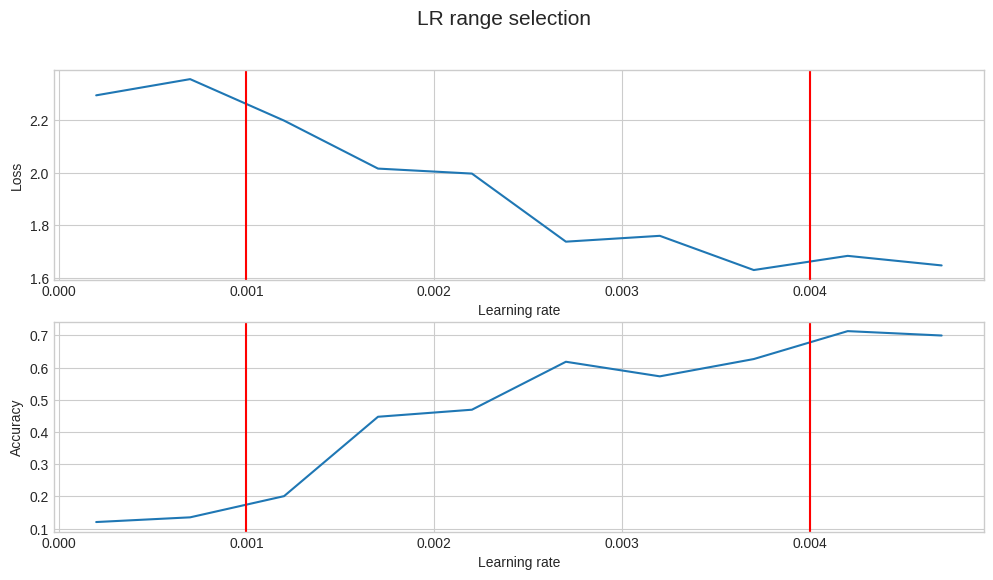

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle("LR range selection", size=15)

ax1.plot(lrs, losses)
ax1.set(xlabel="Learning rate", ylabel="Loss")
ax1.axvline(x=0.001, color="r")
ax1.axvline(x=0.004, color="r")

ax2.plot(lrs, test_accuracy)
ax2.set(xlabel="Learning rate", ylabel="Accuracy")
ax2.axvline(x=0.001, color="r")
ax2.axvline(x=0.004, color="r")

plt.show()

Нас интересует диапазон learning rate, при котором качество начинает сильно расти. Возьмем минимальное значение learning rate $1\cdot10^{-3}$ и максимальное  learning rate $4\cdot10^{-3}$. Максимальное больше минимального в 4 раза (в статье рекомендуют 3–4).


In [ ]:
base_lr = 1e-3
max_lr = 4e-3

Этот `scheduler` надо применять после каждого батча. Поэтому перепишем `train_epoch_sh`:

In [ ]:
def train_epoch_sh(model, optimizer, scheduler, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().numpy())  # write loss to log
        loss.backward()
        optimizer.step()
        scheduler.step()
    return loss_history

#### Запускаем

Вернем размер батча для корректного сравнения.

In [ ]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Размер шага learning rate рекомендуют выбирать каждые 2-8 эпох. Мы возьмем 4.

In [ ]:
step_size_up = 4 * len(train_loader)
print(step_size_up)

7500


In [ ]:
model = SimpleMNIST_NN_Init_Batchnorm(n_layers=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=base_lr)

scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    mode="triangular",
    step_size_up=step_size_up,
)  # first case

В коде ниже мы на каждой эпохе сохраняем лучшую модель.

In [ ]:
from copy import deepcopy


def train_model_cycle_sh(model, optimizer, scheduler, model_name=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs

    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    best_loss = np.inf

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch_sh(
            model, optimizer, scheduler, criterion, train_loader
        )
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)

    return best_model, train_history


model_name = "sgd_cycle_lr"
hooks_data_history = register_model_hooks(model)
best_model, history = train_model_cycle_sh(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

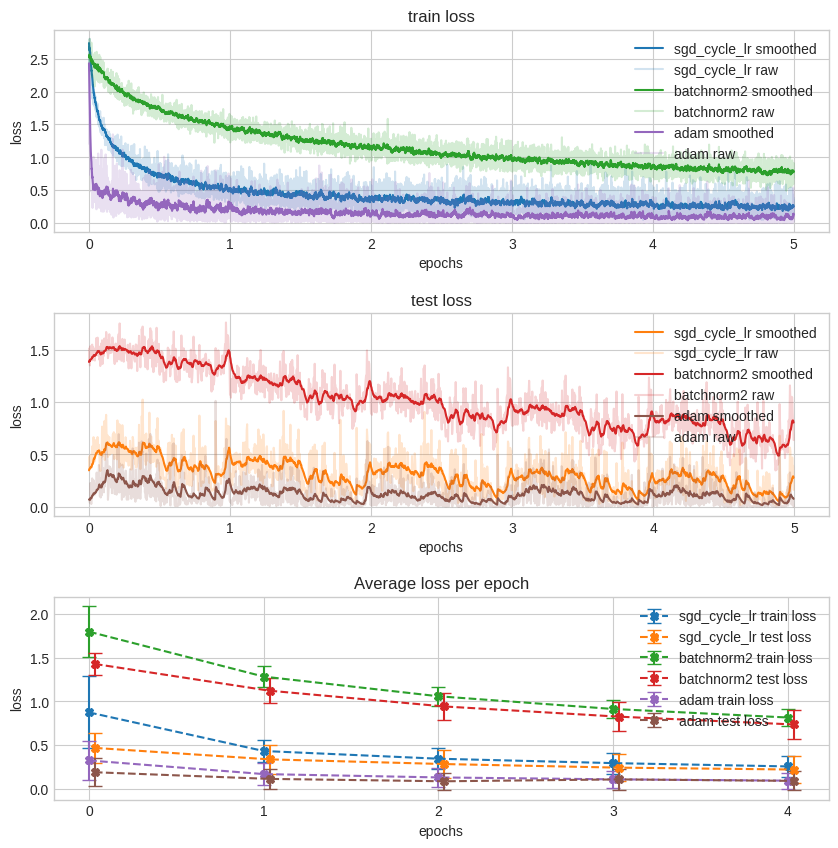

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name, "batchnorm2", "adam"])

Получилось хуже, чем Adam, но лучше, чем SGD, и мы сэкономили память.

### Создание ансамблей моделей

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/Cyclic_LR_Schedule.png" width="750"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Для создания ансамблей моделей learning rate циклически изменяют в сотни раз (а можно и до 0, как ниже), поэтому подбор оптимального значения learning rate не критичен. В качестве правила изменения используют циклический отжиг (cosine annealing cycles):

$$lr(t) = \frac {lr_0}{2}(\cos(\frac{\pi\cdot mod(t-1, [T/M])}{[T/M]})+1)$$

где $lr_0$ — начальная скорость обучения, $T$ — общее количество итераций, $M$ — общее количество моделей, $t$ — текущая итерация.

В формулу можно добавить минимальное значение, но мы это делать не будем, т.к. это не обязательный параметр.


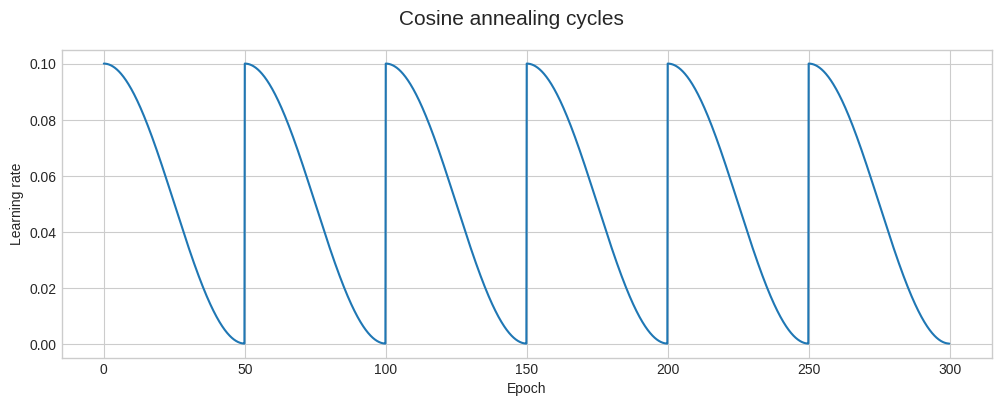

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# number of models (M in formula)
n_models = 6
# epoch per model
epoch = 50
# number of bats in dataset
len_dataset = 8

# total iteration number (T in formula)
total_iter = n_models * epoch * len_dataset

learning_rate_0 = 0.1

t = np.array(range(total_iter))
lr_t = (learning_rate_0 / 2) * (
    np.cos(np.pi * np.mod(t, total_iter / n_models) / (total_iter / n_models)) + 1
)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cosine annealing cycles", size=15)
ax.plot(t / len_dataset, lr_t)
ax.set(xlabel="Epoch", ylabel="Learning rate")
plt.show()

В PyTorch циклический отжиг реализован в модуле `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`.

Общее правило подбора скорости обучения $lr_0$ — она должна быть достаточно большой, чтобы “ломать” обученную модель, при этом количество эпох для обучения каждой модели должно быть достаточным для получения приличного качества. В [статье](https://openreview.net/pdf?id=BJYwwY9ll), например, используют 50 эпох, но это значение будет зависеть от модели.



In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=total_iter // n_models
)

Loss при обучении будет выглядеть примерно так (красная линия):

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/cosine_annealing_cycles.png" width="350"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Модели в конце цикла отжига сохраняются. Можно выбрать лучшую или построить ансамбль.

Интересующимся построением ансамблей нейросетевых моделей советуем ознакомиться с идеей [супа моделей](https://arxiv.org/pdf/2203.05482.pdf).

## Взаимодействие learning schedule и адаптивного изменения learning rate

И то, и другое меняет `learning rate`:

* `learning scheduler` — глобально,

* адаптивные оптимизаторы — для каждого веса отдельно.

Часто их применяют вместе, особенно в случае критерия ранней остановки и WarmUp.

Однако в случае циклического режима обучения так делают не всегда. Дело в том, что одна из его задач — как раз избежать использования адаптивных оптимизаторов, требующих больше памяти и дополнительных вычислений.

При этом никаких препятствий к использованию того же Adam в компании вместе с циклическим режимом обучения нет. Так делают, например, в [статье](https://arxiv.org/pdf/2004.02401.pdf).

Кроме того, есть сложные оптимизаторы, составленные из нескольких простых оптимизаторов и шедулеров. Например, есть проект [Ranger21](https://github.com/lessw2020/Ranger21), не получивший оформления в виде библиотеки на [PyPi](https://pypi.org/), авторы которого пытаются “померить” разные идеи из статей. Подробнее о нем можно почитать в [статье](https://arxiv.org/pdf/2106.13731.pdf).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L07/ranger21.png" width="700"></center>

<center><em>Loss и accuracy при использовании Adam и Ranger21 при обучении ResNet50 на наборе данных ImageNet</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2106.13731.pdf">Ranger21: A Synergistic Deep Learning Optimizer</a></em></center>

Результаты выглядят неплохо. Недостатком этого оптимизатора является большое количество хранимых параметров и гиперпараметров, а также тестирование на ограниченном числе моделей.

<font size = "6">Ссылки:</font>

[A journey into Optimization algorithms for Deep Neural Networks](https://theaisummer.com/optimization/)

[Батч-нормализация. In-layer normalization techniques for training very deep neural networks](https://theaisummer.com/normalization/)

[Разные функции активации, затухающие и взрывающиеся градиенты и т.д.](https://www.kdnuggets.com/2022/06/activation-functions-work-deep-learning.html)

[Визуализация разных оптимизаторов в ipynb, но на tensorflow](https://nbviewer.jupyter.org/github/ilguyi/optimizers.numpy/blob/master/optimizer.tf.all.opt.plot.ipynb)